
##  in progress logs and results
```bash
python vms_gcloud.py benchmark-instance --scp-source 'vm:/solver-benchmark/HiGHS.log' --scp-dest '../results/highs_hipo_full/{vm_name}/HiGHS.log'
python vms_gcloud.py benchmark-instance --scp-source 'vm:/solver-benchmark/results/benchmark_results.csv' --scp-dest '../results/highs_hipo_full/{vm_name}/benchmark_results.csv'
python vms_gcloud.py benchmark-instance  --scp-source 'vm:/var/log/startup-script.log' --scp-dest '../results/highs_hipo_full/{vm_name}/startup-script.log'
```
## run ids from startup-script.log

```bash
# cd solver-benchmark/results/highs_hipo_full
rg  -i 'generated.*run id' **/*.log | awk '{print $NF}
```

- 20251014_141929_benchmark-instance-standard-01
- 20251014_141943_benchmark-instance-highmem-vm-00
- 20251014_141951_benchmark-instance-standard-02
- 20251014_141939_benchmark-instance-highmem-vm-01
- 20251014_141928_benchmark-instance-standard-03
- 20251014_141941_benchmark-instance-highmem-vm-02
- 20251014_141932_benchmark-instance-standard-04
- 20251014_141958_benchmark-instance-highmem-vm-03
- 20251014_141951_benchmark-instance-standard-05
- 20251014_141941_benchmark-instance-highmem-vm-07
- 20251014_141930_benchmark-instance-standard-06
- 20251014_141930_benchmark-instance-standard-06
- 20251014_141930_benchmark-instance-standard-00

## downloading results from gcs

```bash
cd solver-benchmark/gcs-results 
gsutil -m cp -r 'gs://solver-benchmarks/results/20251014_141*' .
```


In [2]:
from pathlib import Path
import yaml
import pandas as pd
import glob
import os
import sys
import re

# Number of HiGHS variants we expect to run per benchmark
NUM_HIGHS_VARIANTS = 5


def load_results(combined_csv_path: Path):
    """
    Load results with preference for GCS (completed) over VM (in-progress) results.
    GCS results are from completed VMs that uploaded to cloud storage.
    VM results are from in-progress VMs accessed via SCP.
    """
    # Try to load from combined CSV first
    if combined_csv_path.exists():
        print(f"Loading combined results from: {combined_csv_path}")
        return pd.read_csv(combined_csv_path)

    # Otherwise, assemble from GCS and VM sources
    results_dir = combined_csv_path.parent
    vm_result_csv_files = glob.glob(str(results_dir / "*" / "benchmark_results.csv"))
    gcs_result_csv_files = glob.glob("../gcs-results/*/*.csv")

    print(f"Found {len(gcs_result_csv_files)} GCS CSV files (completed)")
    print(f"Found {len(vm_result_csv_files)} VM CSV files (in-progress)")

    all_dfs = []
    results_seen = set()

    # First, load GCS results (preferred)
    for csv_file in gcs_result_csv_files:
        df = pd.read_csv(csv_file)
        print(f"  GCS: Read {len(df)} rows from {os.path.basename(os.path.dirname(csv_file))}")
        all_dfs.append(df)
        # Mark this VM as seen
        match = re.findall(r".*(benchmark-instance.*-\d+)", str(csv_file))
        if match:
            results_seen.add(match[0])

    # Then, load VM results (only if not already in GCS)
    for csv_file in vm_result_csv_files:
        vm_name = os.path.basename(os.path.dirname(csv_file))
        # Prefer GCS results to SCP'd results
        if vm_name in results_seen:
            print(f"  VM: Skipping {vm_name} (already loaded from GCS)")
            continue
        df = pd.read_csv(csv_file)
        print(f"  VM: Read {len(df)} rows from {vm_name}")
        all_dfs.append(df)

    if not all_dfs:
        raise FileNotFoundError(f"No results CSVs found at {combined_csv_path}, GCS, or VM directories")

    print(f"\nConcatenating {len(all_dfs)} result files")
    return pd.concat(all_dfs, ignore_index=True)


def ensure_bench_size(results: pd.DataFrame):
    if "bench-size" not in results.columns:
        if "Benchmark" in results.columns and "Size" in results.columns:
            results["bench-size"] = results["Benchmark"].astype(str) + '-' + results["Size"].astype(str)
        elif "Benchmark" in results.columns:
            results["bench-size"] = results["Benchmark"].astype(str)
        elif "Size" in results.columns:
            results["bench-size"] = results["Size"].astype(str)
        else:
            results["bench-size"] = results.index.astype(str)
    return results


def parse_alloc_yaml(yaml_path: Path):
    """Return mapping bench-size -> expected info extracted from the allocation YAML."""
    with open(yaml_path) as fh:
        raw = yaml.safe_load(fh)

    vmname = yaml_path.stem
    machine_type = raw.get("machine-type") or raw.get("machine_type")

    exp_map = {}
    # Expect `benchmarks` -> benchmark_key -> { 'Sizes': [ { 'Name': <size>, '_runtime_s': <s> }, ... ] }
    for bench_key, bench_info in (raw.get("benchmarks") or {}).items():
        sizes = bench_info.get("Sizes") or []
        for s in sizes:
            name = s.get("Name") or s.get("name")
            # _base_runtime_s is the runtime for ONE variant run
            # _runtime_s is typically 5x the base (for all 5 variants)
            base_runtime_s = s.get("_base_runtime_s")
            total_runtime_s = s.get("_runtime_s") or s.get("runtime_s") or s.get("_total_runtime_s")

            # If no base_runtime_s, estimate from total (divide by 5)
            if base_runtime_s is None and total_runtime_s is not None:
                base_runtime_s = total_runtime_s / NUM_HIGHS_VARIANTS

            if name is None:
                continue
            bench_size = f"{bench_key}-{name}"
            exp_map[bench_size] = {
                "vm": vmname,
                "base_runtime_s": float(base_runtime_s) if base_runtime_s is not None else pd.NA,
                "total_runtime_s": float(total_runtime_s) if total_runtime_s is not None else pd.NA,
                "machine_type": machine_type,
                "benchmark_key": bench_key,
                "size_name": name,
            }
    return exp_map


def build_expected_map(alloc_dir: Path):
    expected = {}
    files = sorted(glob.glob(str(alloc_dir / "*.yaml")))
    if not files:
        raise FileNotFoundError(f"No allocation YAMLs found in {alloc_dir}")

    for p in files:
        path = Path(p)
        try:
            m = parse_alloc_yaml(path)
            for k, v in m.items():
                if k in expected:
                    print(f"Warning: duplicate allocation key {k} in {path}; overwriting previous entry")
                expected[k] = v
        except Exception as exc:
            print(f"Failed to parse {path}: {exc}")
    return expected


def normalize_vm_name(vm_name: str) -> str:
    """Normalize VM name by removing common prefixes to enable matching.

    Examples:
        'benchmark-instance-highmem-vm-00' -> 'highmem-vm-00'
        'benchmark-instance-standard-01' -> 'standard-01'
        'highmem-vm-00' -> 'highmem-vm-00'
    """
    if pd.isna(vm_name):
        return "<unknown>"

    vm_str = str(vm_name).strip()
    # Remove common prefixes
    prefixes = ["benchmark-instance-", "instance-"]
    for prefix in prefixes:
        if vm_str.startswith(prefix):
            vm_str = vm_str[len(prefix):]
            break
    return vm_str


def get_timeout_by_machine(runs: pd.DataFrame) -> dict:
    """Infer timeout values by machine type from actual results."""
    timeout_map = {}

    # Find VM hostname column
    vm_col = None
    vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance"}
    for c in runs.columns:
        normalized = c.lower().replace(' ', '').replace('_', '').replace('-', '')
        if normalized in vm_candidates:
            vm_col = c
            break

    if vm_col and "Timeout" in runs.columns:
        # Map hostname patterns to machine types
        for _, row in runs.iterrows():
            hostname = str(row.get(vm_col, ""))
            timeout = row.get("Timeout")

            if pd.notna(timeout):
                if "highmem" in hostname.lower():
                    timeout_map["c4-highmem-8"] = timeout
                elif "standard" in hostname.lower():
                    timeout_map["c4-standard-2"] = timeout

    return timeout_map


def summarize(expected_map: dict, runs: pd.DataFrame):
    # find vm column in runs if present
    vm_col = None
    vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance", "vm_name", "vm-hostname", "vmhostname", "vm host"}
    for c in runs.columns:
        normalized = c.lower().replace(' ', '').replace('_', '').replace('-', '')
        if normalized in vm_candidates:
            vm_col = c
            break

    # Get timeout values by machine type
    timeout_by_machine = get_timeout_by_machine(runs)

    # Prepare runs data (excluding reference benchmarks)
    runs = runs.copy()
    runs = ensure_bench_size(runs)
    actual_runs = runs[runs["Benchmark"] != "reference-benchmark"]

    # Build reverse map: bench-size -> expected VM
    bench_to_expected_vm = {bench_size: normalize_vm_name(info["vm"]) for bench_size, info in expected_map.items()}

    # Validate that benchmarks ran on their expected VMs
    misallocated_benchmarks = []
    for _, row in actual_runs.iterrows():
        bench_size = row.get("bench-size")
        if pd.isna(bench_size):
            continue

        observed_vm = normalize_vm_name(row.get(vm_col) if vm_col else pd.NA)
        expected_vm = bench_to_expected_vm.get(bench_size)

        if expected_vm and observed_vm != expected_vm:
            misallocated_benchmarks.append({
                "bench-size": bench_size,
                "expected_vm": expected_vm,
                "actual_vm": observed_vm,
                "solver": row.get("Solver"),
            })

    if misallocated_benchmarks:
        print("\n" + "="*80)
        print("ERROR: BENCHMARKS RUNNING ON UNEXPECTED VMs")
        print("="*80)
        misalloc_df = pd.DataFrame(misallocated_benchmarks)

        # Group by benchmark to show summary
        print(f"\nFound {len(misallocated_benchmarks)} variant runs on wrong VMs:")
        print(f"Affected benchmarks: {misalloc_df['bench-size'].nunique()}")
        print()

        # Show summary by expected vs actual VM
        print("Misallocation summary:")
        summary = misalloc_df.groupby(["expected_vm", "actual_vm"]).size().reset_index(name="count")
        for _, row in summary.iterrows():
            print(f"  {row['expected_vm']:20s} -> {row['actual_vm']:20s} : {row['count']} variant runs")

        print("\nSample misallocated runs:")
        for i, item in enumerate(misallocated_benchmarks[:20]):
            print(f"  {item['bench-size']:60s} expected={item['expected_vm']:20s} actual={item['actual_vm']:20s} solver={item['solver']}")

        raise ValueError(
            f"Data validation failed: {len(misallocated_benchmarks)} variant runs found on unexpected VMs. "
            f"Check allocation YAMLs vs actual benchmark execution."
        )

    # per-vm expected aggregation with timeout analysis
    per_vm_expected = {}
    for bench_size, info in expected_map.items():
        vm = normalize_vm_name(info.get("vm"))
        machine_type = info.get("machine_type")
        timeout_s = timeout_by_machine.get(machine_type, 3600.0)
        base_runtime_s = info.get("base_runtime_s", 0)

        # Determine if this benchmark will likely timeout (per variant)
        will_timeout = pd.notna(base_runtime_s) and pd.notna(timeout_s) and base_runtime_s >= timeout_s

        per_vm_expected.setdefault(vm, {
            "expected_variants": 0,  # Total variant runs expected (benchmarks × 5)
            "expected_total_s": 0.0,
            "expected_timeout_variants": 0,
            "expected_complete_variants": 0,
            "benchmarks": []
        })

        # Each benchmark expects NUM_HIGHS_VARIANTS runs
        per_vm_expected[vm]["expected_variants"] += NUM_HIGHS_VARIANTS

        if pd.notna(info.get("total_runtime_s")):
            per_vm_expected[vm]["expected_total_s"] += float(info.get("total_runtime_s") or 0.0)

        if will_timeout:
            per_vm_expected[vm]["expected_timeout_variants"] += NUM_HIGHS_VARIANTS
        else:
            per_vm_expected[vm]["expected_complete_variants"] += NUM_HIGHS_VARIANTS

        per_vm_expected[vm]["benchmarks"].append((bench_size, info, will_timeout))

    # per-vm observed aggregation (count actual runs from CSV)
    per_vm_observed = {}
    for _, row in actual_runs.iterrows():
        bench_size = row.get("bench-size")
        if pd.isna(bench_size):
            continue

        observed_vm = row.get(vm_col) if vm_col else pd.NA
        vm = normalize_vm_name(observed_vm)

        per_vm_observed.setdefault(vm, {"completed_variants": 0, "completed_runtime_s": 0.0})
        per_vm_observed[vm]["completed_variants"] += 1

        # Add runtime for this variant run
        rt = row.get("Runtime (s)")
        if pd.notna(rt):
            per_vm_observed[vm]["completed_runtime_s"] += float(rt)

    # Count completed runs per benchmark for remaining work calculation
    benchmark_run_counts = actual_runs.groupby("bench-size").size().to_dict()

    # combine into a summary table
    vms = sorted(set(list(per_vm_expected.keys()) + list(per_vm_observed.keys())))
    rows = []
    for vm in vms:
        exp = per_vm_expected.get(vm, {
            "expected_variants": 0,
            "expected_total_s": 0.0,
            "expected_timeout_variants": 0,
            "expected_complete_variants": 0
        })
        obs = per_vm_observed.get(vm, {"completed_variants": 0, "completed_runtime_s": 0.0})

        remaining_variants = exp["expected_variants"] - obs["completed_variants"]
        remaining_s = max(0.0, exp["expected_total_s"] - obs["completed_runtime_s"])

        # Calculate real remaining work (only non-timeout variants that haven't run)
        pending_timeout_variants = 0
        pending_complete_variants = 0
        pending_real_work_s = 0.0

        if vm in per_vm_expected:
            for bench_size, info, will_timeout in exp["benchmarks"]:
                # How many variants have already run for this benchmark?
                completed_for_bench = benchmark_run_counts.get(bench_size, 0)
                remaining_for_bench = NUM_HIGHS_VARIANTS - completed_for_bench

                if remaining_for_bench > 0:
                    if will_timeout:
                        pending_timeout_variants += remaining_for_bench
                    else:
                        pending_complete_variants += remaining_for_bench
                        # Calculate remaining work: (remaining variants / total variants) × total_runtime
                        if pd.notna(info.get("total_runtime_s")):
                            fraction_remaining = remaining_for_bench / NUM_HIGHS_VARIANTS
                            pending_real_work_s += float(info.get("total_runtime_s", 0)) * fraction_remaining

        rows.append({
            "vm": vm,
            "expected_variants": exp["expected_variants"],
            "expected_total_h": exp["expected_total_s"] / 3600,
            "completed_variants": obs["completed_variants"],
            "completed_runtime_h": obs["completed_runtime_s"] / 3600,
            "remaining_variants": remaining_variants,
            "remaining_expected_h": remaining_s / 3600,
            "remaining_real_work_h": pending_real_work_s / 3600,
            "pending_timeout_variants": pending_timeout_variants,
            "pending_complete_variants": pending_complete_variants,
        })

    df = pd.DataFrame(rows).sort_values("vm")

    print("\nPer-VM expected vs observed summary:")
    print(f"(Each benchmark needs {NUM_HIGHS_VARIANTS} variant runs to complete)")
    if df.empty:
        print("  (no VMs found)")
    else:
        # pretty print
        with pd.option_context('display.float_format', '{:,.1f}'.format):
            print(df.to_string(index=False))

    # Summary of pending work
    total_pending_timeout = df["pending_timeout_variants"].sum()
    total_pending_complete = df["pending_complete_variants"].sum()
    total_real_work_h = df["remaining_real_work_h"].sum()

    print(f"\nPending variant runs breakdown:")
    print(f"  Total pending variants: {total_pending_timeout + total_pending_complete}")
    print(f"  Expected to timeout: {total_pending_timeout}")
    print(f"  Expected to complete: {total_pending_complete}")
    print(f"  Real work remaining: {total_real_work_h:.1f}h (excludes timeout variants)")

    # Show some incomplete benchmarks
    print(f"\nBenchmark completion status:")
    benchmark_list = []
    for bench_size, info in expected_map.items():
        completed_variants = benchmark_run_counts.get(bench_size, 0)
        if completed_variants < NUM_HIGHS_VARIANTS:
            base_h = info.get("base_runtime_s", 0) / 3600
            machine = info.get("machine_type")
            timeout_s = timeout_by_machine.get(machine, 3600.0)
            timeout_h = timeout_s / 3600
            will_timeout = "TIMEOUT" if base_h >= timeout_h else "complete"
            benchmark_list.append((bench_size, info.get("vm"), completed_variants, will_timeout, base_h, timeout_h))

    print(f"  Total benchmarks: {len(expected_map)}")
    print(f"  Fully complete (5/5 variants): {len([b for b in benchmark_run_counts.values() if b >= NUM_HIGHS_VARIANTS])}")
    print(f"  Partially complete: {len([b for b in benchmark_run_counts.values() if 0 < b < NUM_HIGHS_VARIANTS])}")
    print(f"  Not started: {len(expected_map) - len(benchmark_run_counts)}")

    if benchmark_list:
        print(f"\nSample incomplete benchmarks:")
        for bench, vm, completed, status, base_h, timeout_h in sorted(benchmark_list):
            print(f"  - {bench:60s} ({completed}/{NUM_HIGHS_VARIANTS} variants, vm={vm}, base={base_h:5.1f}h, timeout={timeout_h:5.1f}h) [{status}]")


def main():
    repo_root = Path("../")
    # combined_csv = repo_root / "results" / "highs_hipo_full" / "combined_highs_results.csv"
    combined_csv = repo_root / "results" / "highs_l_size" / "combined_highs_results.csv"
    # alloc_dir = repo_root / "infrastructure" / "benchmarks" / "runtime_optimized"
    alloc_dir = repo_root / "infrastructure" / "benchmarks" / "phase_1_parallel"

    try:
        runs = load_results(combined_csv)
        actual_runs = runs[runs["Benchmark"] != "reference-benchmark"]
        actual_runs.to_csv('../results/benchmark_results.csv')
    except Exception as exc:
        print(f"Failed to load results: {exc}")
        sys.exit(1)

    runs = ensure_bench_size(runs)

    try:
        expected_map = build_expected_map(alloc_dir)
    except Exception as exc:
        print(f"Failed to build expected map from {alloc_dir}: {exc}")
        sys.exit(1)

    # summarize(expected_map, runs)
main()

Found 15 GCS CSV files (completed)
Found 16 VM CSV files (in-progress)
  GCS: Read 34 rows from 20251014_141939_benchmark-instance-highmem-vm-01
  GCS: Read 10 rows from 20251014_141944_benchmark-instance-highmem-vm-04
  GCS: Read 96 rows from 20251014_141928_benchmark-instance-standard-03
  GCS: Read 96 rows from 20251014_141929_benchmark-instance-standard-01
  GCS: Read 10 rows from 20251014_141941_benchmark-instance-highmem-vm-07
  GCS: Read 105 rows from 20251014_141930_benchmark-instance-standard-00
  GCS: Read 37 rows from 20251014_141941_benchmark-instance-highmem-vm-02
  GCS: Read 10 rows from 20251014_142001_benchmark-instance-highmem-vm-05
  GCS: Read 9 rows from 20251014_141959_benchmark-instance-highmem-vm-06
  GCS: Read 92 rows from 20251014_141951_benchmark-instance-standard-05
  GCS: Read 101 rows from 20251014_141951_benchmark-instance-standard-02
  GCS: Read 119 rows from 20251014_141932_benchmark-instance-standard-04
  GCS: Read 101 rows from 20251014_141930_benchmark

In [2]:
# Gather results from full run
import pandas as pd
import glob
import os
from pathlib import Path
import re

# Find all benchmark_results.csv files in the highs_hipo_full directory
results_dir = "../results/highs_hipo_full"
vm_result_csv_files = glob.glob(f"{results_dir}/*/benchmark_results.csv")
gcs_result_csv_files = glob.glob(f"../gcs-results/*/*.csv")

print(f"Found {len(vm_result_csv_files)} CSV files")

# Read and concatenate all CSV files
all_dfs = []
results_seen = set()
for csv_file in gcs_result_csv_files:
    df = pd.read_csv(csv_file)
    print(f"Read {len(df)} rows from {os.path.basename(os.path.dirname(csv_file))}")
    all_dfs.append(df)
    results_seen.add(re.findall(r".*(benchmark-instance.*-\d+)", str(csv_file))[0])

for csv_file in vm_result_csv_files:
    vm_name = os.path.basename(os.path.dirname(csv_file))
    # prefer gcs results to scp'd results before machine deletion
    if vm_name in results_seen:
        print(f"Skipping {vm_name} (already loaded from GCS)")
        continue
    df = pd.read_csv(csv_file)
    print(f"Read {len(df)} rows from {vm_name}")
    all_dfs.append(df)

# Concatenate all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Save to highs_results.csv
    output_file = Path(results_dir) / "combined_highs_results.csv"
    combined_df.to_csv(output_file, index=False)

    # Also expose as `results` for downstream cells when running this notebook interactively
    results = combined_df

    print(f"\nSuccessfully gathered {len(combined_df)} total rows")
    print(f"Saved to: {output_file}")
    print(f"\nColumns: {list(combined_df.columns)}")
    print(f"Shape: {combined_df.shape}")
    print(f"\nSolver breakdown:")
    print(combined_df['Solver'].value_counts())

    # Shared helper: ensure bench-size column exists
    def ensure_bench_size(df):
        """Add bench-size column if not present."""
        if 'bench-size' not in df.columns:
            if 'Benchmark' in df.columns and 'Size' in df.columns:
                df['bench-size'] = df['Benchmark'].astype(str) + '-' + df['Size'].astype(str)
            elif 'Benchmark' in df.columns:
                df['bench-size'] = df['Benchmark'].astype(str)
            elif 'Size' in df.columns:
                df['bench-size'] = df['Size'].astype(str)
            else:
                df['bench-size'] = df.index.astype(str)
        return df

    # Shared helper: detect VM hostname column
    def detect_vm_column(df):
        """Detect the VM hostname column name."""
        vm_candidates = {"hostname", "host", "vmhostname", "vm", "instancename", "instance", "vm_name", "vm-hostname", "vmhostname", "vm host"}
        for col in df.columns:
            normalized = col.lower().replace(' ', '').replace('_', '').replace('-', '')
            if normalized in vm_candidates:
                return col
        return None

    # Apply to results
    results = ensure_bench_size(results)
    vm_col = detect_vm_column(results)
    if vm_col:
        print(f"Detected VM hostname column: {vm_col}")

else:
    print("No data to combine")


# Compare HiGHS 1.11.x variants vs highs 1.10.0 baseline
# We'll treat each 1.11.x variant separately using the 'Solver' column so variants aren't lumped together.

# Use the already-loaded results variable
if 'results' not in globals():
    raise RuntimeError("`results` DataFrame not available. Run the data gathering cell first.")

# Extract baseline (1.10.0) results and exclude reference sizes
highs_110 = results[(results["Solver Version"] == "1.10.0") & (results["Size"] != "reference")].copy()
# Extract all 1.11.x results (may have different solver names for variants)
highs_111_all = results[results["Solver Version"].astype(str).str.startswith("1.11.0")].copy()

print(f"Found {len(highs_110)} results for highs-1.10.0")
print(f"Found {len(highs_111_all)} results for highs-1.11.x variants")

# Ensure required columns exist in both dataframes; if not, create them with pd.NA so selection never KeyErrors
required_cols = ["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
for col in required_cols:
    if col not in highs_110.columns:
        highs_110[col] = pd.NA
    if col not in highs_111_all.columns:
        highs_111_all[col] = pd.NA

# Load benchmark metadata to map (Benchmark, Size) -> Size label (S/M/L)
meta_path = Path('../results/metadata.yaml')
size_map = {}
try:
    import yaml
    with open(meta_path) as fh:
        meta = yaml.safe_load(fh)
    benchmarks_meta = meta.get('benchmarks', {}) if isinstance(meta, dict) else {}
    for bench_key, bench_info in benchmarks_meta.items():
        sizes = bench_info.get('Sizes') or []
        for s in sizes:
            name = s.get('Name')
            size_label = s.get('Size')
            if name and size_label:
                size_map[(bench_key, str(name))] = size_label
except Exception as e:
    print(f"Could not load metadata.yaml for bench-size labels: {e}")

# Prepare baseline frame keyed by bench-size
# Include Objective Value for baseline and preserve Benchmark column (we need it for metadata lookup)
baseline_df = highs_110[["bench-size", "Benchmark", "Size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]].rename(columns={
    "Runtime (s)": "highs_1.10.0_runtime",
    "Memory Usage (MB)": "highs_1.10.0_memory",
    "Status": "highs_1.10.0_status",
    "Objective Value": "highs_1.10.0_objective"
})

# If VM column detected, include baseline VM hostname
if vm_col and vm_col in highs_110.columns:
    baseline_df = baseline_df.merge(highs_110[["bench-size", vm_col]], on="bench-size", how="left").rename(columns={vm_col: "baseline_vm_hostname"})
else:
    baseline_df["baseline_vm_hostname"] = pd.NA

# We'll iterate over each distinct Solver name in the 1.11.x set so variants are kept separate
variant_names = sorted(highs_111_all["Solver"].fillna("<unknown>").unique())
comparison_rows = []
summary_frames = []

for variant in variant_names:
    # Include Objective Value for variant runs and VM hostname if available
    # NOTE: do NOT include 'Size' here; keep Size only from baseline to avoid pandas creating Size_x/Size_y columns
    sel_cols = ["bench-size", "Runtime (s)", "Memory Usage (MB)", "Status", "Objective Value"]
    if vm_col and vm_col in highs_111_all.columns:
        sel_cols.append(vm_col)

    variant_df = highs_111_all[highs_111_all["Solver"] == variant][sel_cols].rename(columns={
        "Runtime (s)": "variant_runtime",
        "Memory Usage (MB)": "variant_memory",
        "Status": "variant_status",
        "Objective Value": "variant_objective"
    })

    # If VM column present, rename it for the variant
    if vm_col and vm_col in variant_df.columns:
        variant_df = variant_df.rename(columns={vm_col: "variant_vm_hostname"})
    else:
        variant_df["variant_vm_hostname"] = pd.NA

    merged = baseline_df.merge(variant_df, on="bench-size", how="inner")
    if len(merged) == 0:
        continue

    # add variant name for grouping and clarity
    merged["variant_solver"] = variant

    # Map bench-size label (S/M/L) using metadata; try some normalization fallbacks
    def _lookup_size_label(row):
        bench = row.get('Benchmark')
        size_name = row.get('Size')
        if pd.notna(bench) and pd.notna(size_name):
            # try direct match
            key = (bench, str(size_name))
            if key in size_map:
                return size_map[key]
            # try underscore/dash variants and lowercase variants
            alt_keys = [
                (bench.replace('_', '-'), str(size_name)),
                (bench.replace('-', '_'), str(size_name)),
                (bench.lower(), str(size_name)),
                (bench.lower().replace('_', '-'), str(size_name)),
                (bench.lower().replace('-', '_'), str(size_name)),
            ]
            for k in alt_keys:
                if k in size_map:
                    return size_map[k]
        return pd.NA

    merged["bench_size_label"] = merged.apply(_lookup_size_label, axis=1)

    # Compute metrics: speedup (baseline / variant), absolute time diff and memory diff
    # Protect against division by zero / missing runtimes
    merged["runtime_speedup"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] / r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) and r["variant_runtime"] != 0 else pd.NA, axis=1)
    merged["runtime_diff_seconds"] = merged.apply(lambda r: (r["highs_1.10.0_runtime"] - r["variant_runtime"]) if pd.notna(r["highs_1.10.0_runtime"]) and pd.notna(r["variant_runtime"]) else pd.NA, axis=1)
    merged["memory_diff_mb"] = merged.apply(lambda r: (r["highs_1.10.0_memory"] - r["variant_memory"]) if pd.notna(r["highs_1.10.0_memory"]) and pd.notna(r["variant_memory"]) else pd.NA, axis=1)

    # Compute objective difference when available (baseline - variant)
    def _calc_obj_diff(row):
        try:
            if pd.notna(row.get("highs_1.10.0_objective")) and pd.notna(row.get("variant_objective")):
                return row["highs_1.10.0_objective"] - row["variant_objective"]
        except Exception:
            return pd.NA
        return pd.NA

    merged["objective_diff"] = merged.apply(_calc_obj_diff, axis=1)

    # Keep only rows where both runs succeeded for 'better/worse' classification
    both_ok = (merged["highs_1.10.0_status"] == "ok") & (merged["variant_status"] == "ok")
    merged_ok = merged[both_ok].copy()

    # Sort by speedup magnitude
    merged_ok = merged_ok.sort_values("runtime_speedup", ascending=False)

    # Save per-variant CSVs (better/worse relative to baseline). Include bench-size and objective columns in outputs
    variant_better = merged_ok[merged_ok["runtime_speedup"] > 1.0].copy()
    variant_worse = merged_ok[merged_ok["runtime_speedup"] < 1.0].copy()

    out_cols = [
        # Baseline group
        "bench-size",
        "Benchmark",
        "Size",
        "bench_size_label",
        "highs_1.10.0_runtime",
        "highs_1.10.0_memory",
        "highs_1.10.0_objective",
        "highs_1.10.0_status",
        "baseline_vm_hostname",
        # Variant group
        "variant_solver",
        "variant_runtime",
        "variant_memory",
        "variant_objective",
        "variant_status",
        "variant_vm_hostname",
        # Diffs / derived
        "runtime_speedup",
        "runtime_diff_seconds",
        "memory_diff_mb",
        "objective_diff",
    ]

    # Sort outputs by bench-size for readability
    if not variant_better.empty:
        variant_better = variant_better.sort_values("bench-size")
    if not variant_worse.empty:
        variant_worse = variant_worse.sort_values("bench-size")

    if len(variant_better) > 0:
        variant_better.to_csv(f"../hipo_better_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_better.columns])
    if len(variant_worse) > 0:
        variant_worse.to_csv(f"../hipo_worse_{variant.replace(' ', '_')}.csv", index=False, columns=[c for c in out_cols if c in variant_worse.columns])

    # keep for combined summary (include all merged rows, not only ok ones)
    summary_frames.append(merged)

# Combine all variant comparisons into a single dataframe for overview
if summary_frames:
    comparison_df = pd.concat(summary_frames, ignore_index=True)
    # sort combined overview by bench-size as well
    if 'bench-size' in comparison_df.columns:
        comparison_df = comparison_df.sort_values("bench-size")
    print(f"Combined comparison dataframe shape: {comparison_df.shape}")
else:
    comparison_df = pd.DataFrame()
    print("No matching benchmarks found between baseline and 1.11.x variants.")

# Show aggregate better/worse counts per variant (only where both succeeded)
if not comparison_df.empty:
    both_ok_mask = (comparison_df["highs_1.10.0_status"] == "ok") & (comparison_df["variant_status"] == "ok")
    agg = comparison_df[both_ok_mask].groupby("variant_solver")["runtime_speedup"].agg(["count", "mean", "median"]).rename(columns={"count": "matched_count"})
    print("\nPer-variant summary (matched runs only):")
    print(agg.round(3))

    # Save combined overview CSV
    # Include bench-size and objective columns
    cols_for_overview = [
        # Baseline group first
        "bench-size",
        # "Benchmark",
        # "Size",
        "bench_size_label",
        "variant_solver",
        "highs_1.10.0_status",
        "variant_status",
        "baseline_vm_hostname",
        "variant_vm_hostname",
        "highs_1.10.0_runtime",
        "variant_runtime",
        "runtime_diff_seconds",
        "runtime_speedup",
        "highs_1.10.0_memory",
        "variant_memory",
        "memory_diff_mb",
        "highs_1.10.0_objective",
        "variant_objective",
        "objective_diff",
    ]

    comparison_df.to_csv("../hipo_comparison_all_variants.csv", index=False, columns=[c for c in cols_for_overview if c in comparison_df.columns])
# End of comparison cell

Found 28 CSV files
Read 34 rows from 20251014_141939_benchmark-instance-highmem-vm-01
Read 10 rows from 20251014_141944_benchmark-instance-highmem-vm-04
Read 96 rows from 20251014_141928_benchmark-instance-standard-03
Read 96 rows from 20251014_141929_benchmark-instance-standard-01
Read 10 rows from 20251014_141941_benchmark-instance-highmem-vm-07
Read 105 rows from 20251014_141930_benchmark-instance-standard-00
Read 37 rows from 20251014_141941_benchmark-instance-highmem-vm-02
Read 10 rows from 20251014_142001_benchmark-instance-highmem-vm-05
Read 9 rows from 20251014_141959_benchmark-instance-highmem-vm-06
Read 92 rows from 20251014_141951_benchmark-instance-standard-05
Read 101 rows from 20251014_141951_benchmark-instance-standard-02
Read 119 rows from 20251014_141932_benchmark-instance-standard-04
Read 101 rows from 20251014_141930_benchmark-instance-standard-06
Read 20 rows from 20251014_141943_benchmark-instance-highmem-vm-00
Read 10 rows from 20251014_141958_benchmark-instance-h

## How do HiGHS variants compare?

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [4]:
# Color map for HiGHS variants and other solvers
color_map = {
    "highs": "#43BF94",  # green - baseline
    "highs-binary": "#2D8A63",  # darker green
    "highs-hipo": "#F66C49",  # red/orange - primary HIPO variant
    "highs-hipo-ipm": "#F9A826",  # orange
    "highs-hipo-32": "#3B82F6",  # blue
    "highs-hipo-64": "#7C3AED",  # purple
    "highs-hipo-128": "#8B5CF6",  # lighter purple
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#9333EA",  # purple
    "gurobi": "#DC2626",  # bright red
    "scip": "#0EA5E9",  # sky blue
}


def plot_single_benchmark_comparison(df, benchmark_name, num_vars=None, figsize=(10, 6)):
    """Plot a single benchmark with solvers on x-axis.

    Args:
        df: DataFrame with benchmark results
        benchmark_name: The bench-size to plot
        figsize: Figure size tuple
    """
    # Filter to single benchmark
    bench_data = df[df["bench-size"] == benchmark_name].copy()

    if len(bench_data) == 0:
        print(f"No data found for benchmark: {benchmark_name}")
        return

    # Remove old solver versions if multiple versions exist
    bench_data = bench_data.sort_values(["Solver", "Solver Release Year"]).drop_duplicates(["Solver"], keep="last")

    # Identify successful vs failed runs
    bench_data["Success"] = bench_data["Status"] == "ok"

    # Find fastest successful solver
    successful_data = bench_data[bench_data["Success"]]
    if len(successful_data) == 0:
        print(f"No successful runs for benchmark: {benchmark_name}")
        return

    fastest_runtime = successful_data["Runtime (s)"].min()

    # Calculate slowdown for successful runs only
    bench_data.loc[bench_data["Success"], "Slowdown"] = bench_data.loc[bench_data["Success"], "Runtime (s)"] / fastest_runtime

    # For failed runs, don't calculate slowdown (will plot differently)
    bench_data.loc[~bench_data["Success"], "Slowdown"] = 0

    # Sort: successful runs by slowdown, then failed runs
    bench_data = bench_data.sort_values(["Success", "Slowdown"], ascending=[False, True])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Separate successful and failed data
    slowdowns = []
    colors_list = []

    for _, row in bench_data.iterrows():
        if row["Success"]:
            slowdowns.append(row["Slowdown"])
            colors_list.append(color_map.get(row["Solver"], "#888888"))
        else:
            slowdowns.append(0)  # Don't show bar for failed runs
            colors_list.append((color_map.get(row["Solver"], "#888888"), 0.2))

    # Create bars
    bars = ax.bar(range(len(bench_data)), slowdowns, color=colors_list)

    # Add horizontal line at y=1
    ax.axhline(1, color="grey", linestyle="--", linewidth=1, alpha=0.7)

    # Calculate max slowdown for positioning failed labels
    max_slowdown = bench_data[bench_data["Success"]]["Slowdown"].max() if len(successful_data) > 0 else 1

    # Add value labels on bars
    for i, (_, row) in enumerate(bench_data.iterrows()):
        if row["Success"]:
            label = f"{row['Slowdown']:.2f}x\n{naturaldelta(row['Runtime (s)'])}"
            y_pos = row["Slowdown"] + max_slowdown * 0.02
            color = "black"
            weight = "normal"
        else:
            # For non-ok status, show the actual status value
            label = str(row["Status"])
            y_pos = max_slowdown * 0.5  # Position in middle of plot area
            color = "red"
            weight = "bold"

        ax.text(i, y_pos, label,
                ha="center", va="bottom" if row["Success"] else "center",
                fontsize=10 if not row["Success"] else 9,
                color=color, weight=weight)

    # Set x-axis to solver names
    ax.set_xticks(range(len(bench_data)))
    ax.set_xticklabels(bench_data["Solver"], rotation=45, ha="right")

    # Labels and title
    ax.set_xlabel("Solver", fontsize=11)
    ax.set_ylabel("Relative Runtime (normalized to fastest)", fontsize=11)
    num_vars_str = f" ({num_vars:,} variables)" if isinstance(num_vars, int) else (" (N/A variables)" if num_vars else "")
    ax.set_title(f"Solver Performance Comparison\n{benchmark_name}{num_vars_str}", fontsize=12, weight="bold")

    # Add grid for easier reading
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add some padding at the top for labels
    ax.set_ylim(0, max_slowdown * 1.15)

    plt.tight_layout()

    return fig, ax

In [5]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions if multiple versions exist
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)

### All Benchmarks Comparison

In [6]:
# Filter out reference benchmarks
actual_benchmarks = results[results["Benchmark"] != "reference-benchmark"].copy()
print(actual_benchmarks.columns)

# Get unique benchmark-size combinations
unique_benchmarks = actual_benchmarks["bench-size"].unique()

# print(f"Found {len(unique_benchmarks)} unique benchmarks:")
# for b in sorted(unique_benchmarks):
#     print(f"  - {b}")

Index(['Benchmark', 'Size', 'Solver', 'Solver Version', 'Solver Release Year',
       'Status', 'Termination Condition', 'Runtime (s)', 'Memory Usage (MB)',
       'Objective Value', 'Max Integrality Violation', 'Duality Gap',
       'Reported Runtime (s)', 'Timeout', 'Hostname', 'Run ID', 'Timestamp',
       'bench-size'],
      dtype='object')


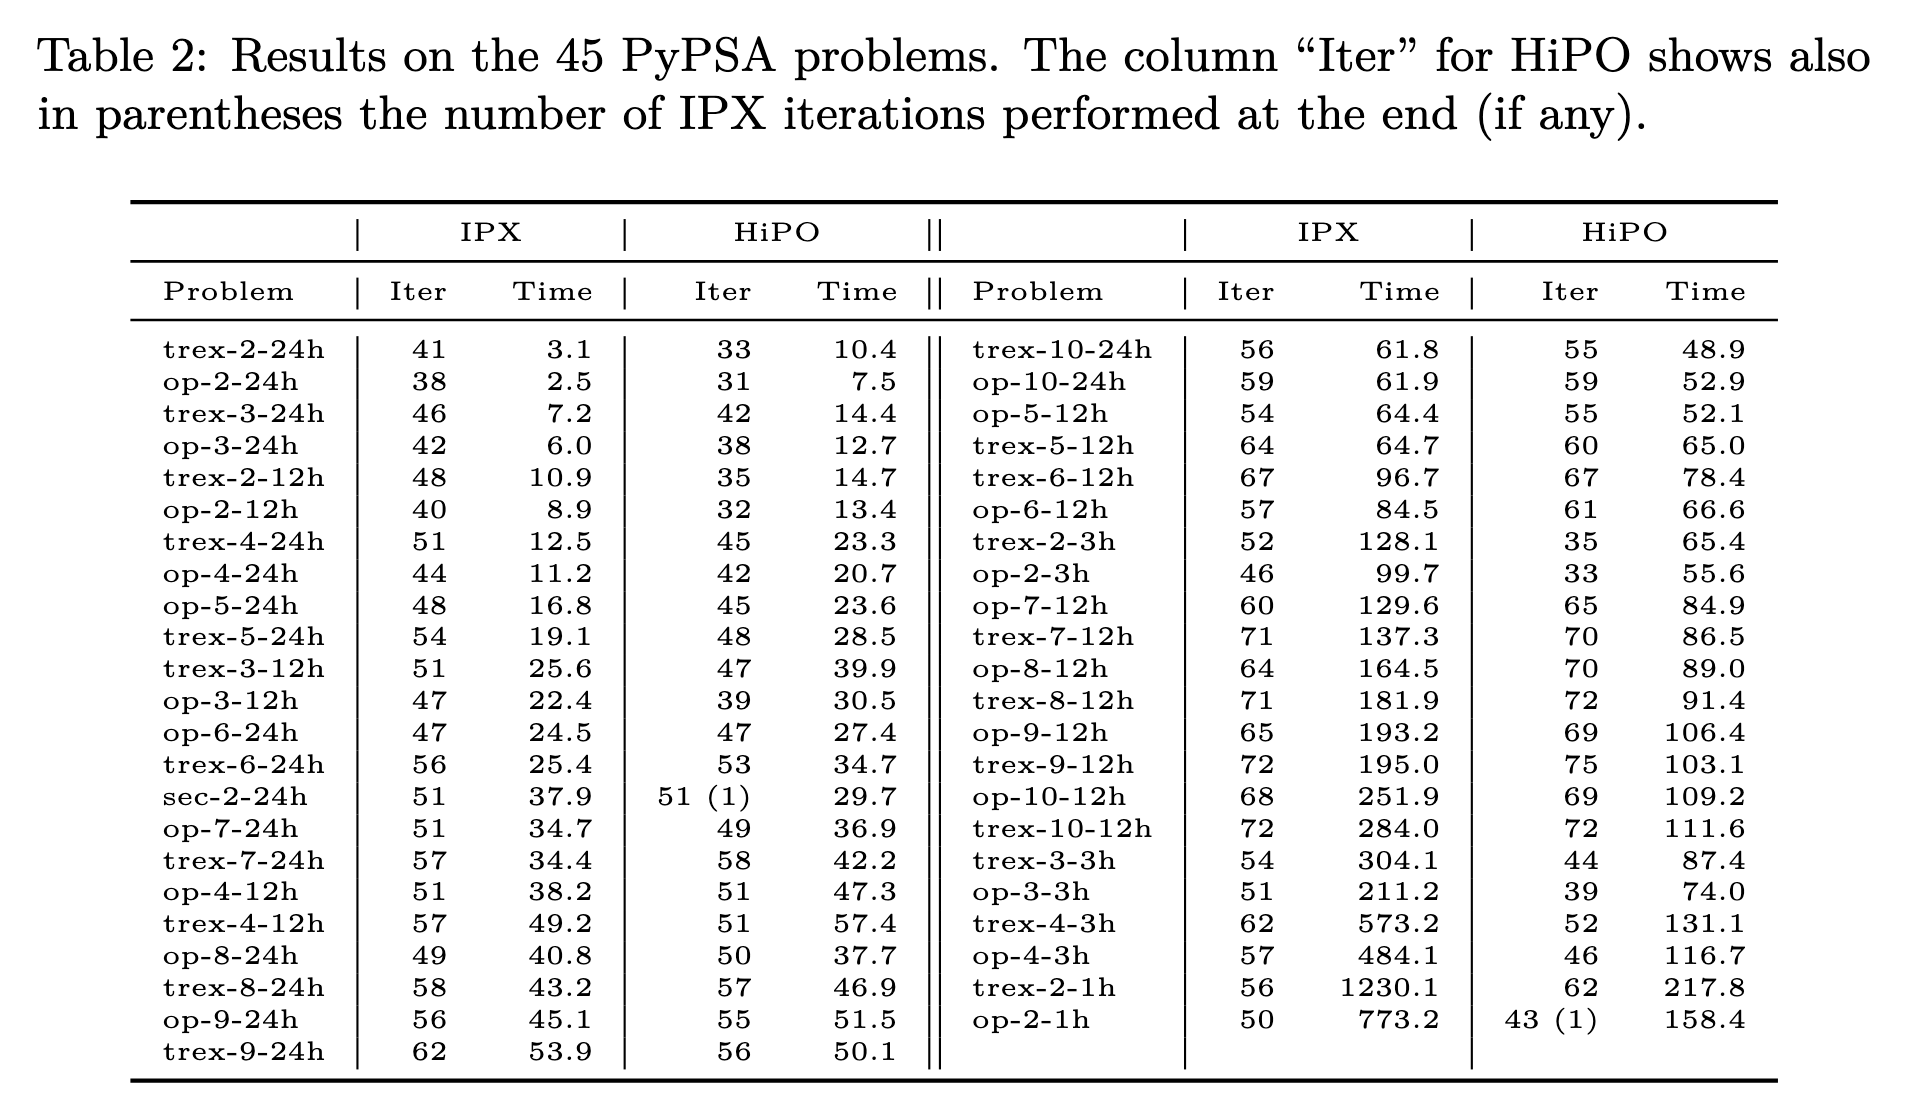

In [7]:
# HiPO paper results from Table 2: Results on the 45 PyPSA problems
# IPX is the baseline (HiGHS 1.10.0), HiPO is the improved version
hipo_paper_results = {
    # Format: benchmark_name: {"ipx_time": baseline_time, "hipo_time": hipo_time}
    "trex-2-24h": {"ipx_time": 3.1, "hipo_time": 10.4},
    "op-2-24h": {"ipx_time": 2.5, "hipo_time": 7.5},
    "trex-3-24h": {"ipx_time": 7.2, "hipo_time": 14.4},
    "op-3-24h": {"ipx_time": 6.0, "hipo_time": 12.7},
    "trex-2-12h": {"ipx_time": 10.9, "hipo_time": 14.7},
    "op-2-12h": {"ipx_time": 8.9, "hipo_time": 13.4},
    "trex-4-24h": {"ipx_time": 12.5, "hipo_time": 23.3},
    "op-4-24h": {"ipx_time": 11.2, "hipo_time": 20.7},
    "op-5-24h": {"ipx_time": 16.8, "hipo_time": 23.6},
    "trex-5-24h": {"ipx_time": 19.1, "hipo_time": 28.5},
    "trex-3-12h": {"ipx_time": 25.6, "hipo_time": 39.9},
    "op-3-12h": {"ipx_time": 22.4, "hipo_time": 30.5},
    "op-6-24h": {"ipx_time": 24.5, "hipo_time": 27.4},
    "trex-6-24h": {"ipx_time": 25.4, "hipo_time": 34.7},
    "sec-2-24h": {"ipx_time": 37.9, "hipo_time": 29.7},
    "op-7-24h": {"ipx_time": 34.7, "hipo_time": 36.9},
    "trex-7-24h": {"ipx_time": 34.4, "hipo_time": 42.2},
    "op-4-12h": {"ipx_time": 38.2, "hipo_time": 47.3},
    "trex-4-12h": {"ipx_time": 49.2, "hipo_time": 57.4},
    "op-8-24h": {"ipx_time": 40.8, "hipo_time": 37.7},
    "trex-8-24h": {"ipx_time": 43.2, "hipo_time": 46.9},
    "op-9-24h": {"ipx_time": 45.1, "hipo_time": 51.5},
    "trex-9-24h": {"ipx_time": 53.9, "hipo_time": 50.1},
    "trex-10-24h": {"ipx_time": 61.8, "hipo_time": 48.9},
    "op-10-24h": {"ipx_time": 61.9, "hipo_time": 52.9},
    "op-5-12h": {"ipx_time": 64.4, "hipo_time": 52.1},
    "trex-5-12h": {"ipx_time": 64.7, "hipo_time": 65.0},
    "trex-6-12h": {"ipx_time": 96.7, "hipo_time": 78.4},
    "op-6-12h": {"ipx_time": 84.5, "hipo_time": 66.6},
    "trex-2-3h": {"ipx_time": 128.1, "hipo_time": 65.4},
    "op-2-3h": {"ipx_time": 99.7, "hipo_time": 55.6},
    "op-7-12h": {"ipx_time": 129.6, "hipo_time": 84.9},
    "trex-7-12h": {"ipx_time": 137.3, "hipo_time": 86.5},
    "op-8-12h": {"ipx_time": 164.5, "hipo_time": 89.0},
    "trex-8-12h": {"ipx_time": 181.9, "hipo_time": 91.4},
    "op-9-12h": {"ipx_time": 193.2, "hipo_time": 106.4},
    "trex-9-12h": {"ipx_time": 195.0, "hipo_time": 103.1},
    "op-10-12h": {"ipx_time": 251.9, "hipo_time": 109.2},
    "trex-10-12h": {"ipx_time": 284.0, "hipo_time": 111.6},
    "trex-3-3h": {"ipx_time": 304.1, "hipo_time": 87.4},
    "op-3-3h": {"ipx_time": 211.2, "hipo_time": 74.0},
    "trex-4-3h": {"ipx_time": 573.2, "hipo_time": 131.1},
    "op-4-3h": {"ipx_time": 484.1, "hipo_time": 116.7},
    "trex-2-1h": {"ipx_time": 1230.1, "hipo_time": 217.8},
    "op-2-1h": {"ipx_time": 773.2, "hipo_time": 158.4},
}
not_handled_paper_benchmarks = set(hipo_paper_results.keys())


COMPARISON WITH HIPO PAPER RESULTS

Benchmark: pypsa-eur-elec-op-2-1h - Variables: 455,458 (M)
Paper results - IPX (baseline): 773.2s, HiPO: 158.4s, Speedup: 4.88x
Our runtimes - highs-hipo-ipm: 547.7s, highs-1.10: 1913.6s, Gurobi: 98.3s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.36x, Diff vs paper: -2.52x (worse)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.09x, Diff vs paper: -2.80x (worse)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.08x, Diff vs paper: -2.80x (worse)


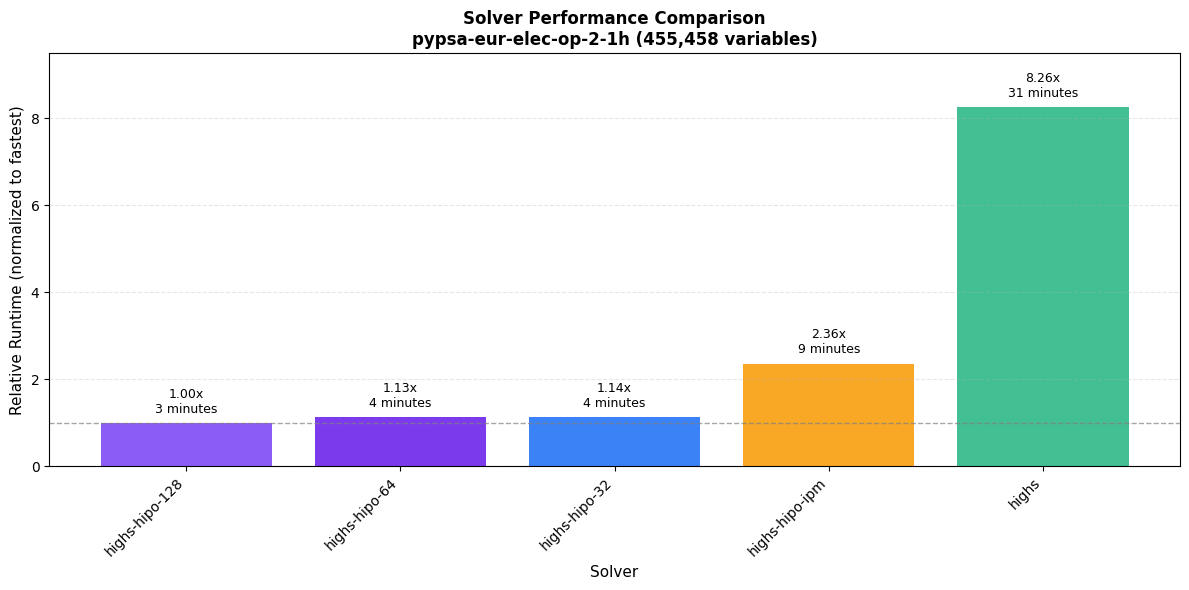


Benchmark: pypsa-eur-elec-op-4-3h - Variables: 318,278 (M)
Paper results - IPX (baseline): 484.1s, HiPO: 116.7s, Speedup: 4.15x
Our runtimes - highs-hipo-ipm: 347.3s, highs-1.10: 2857.7s, Gurobi: 112.6s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 4.44x, Diff vs paper: +0.29x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.59x, Diff vs paper: +0.44x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 4.51x, Diff vs paper: +0.36x (better)


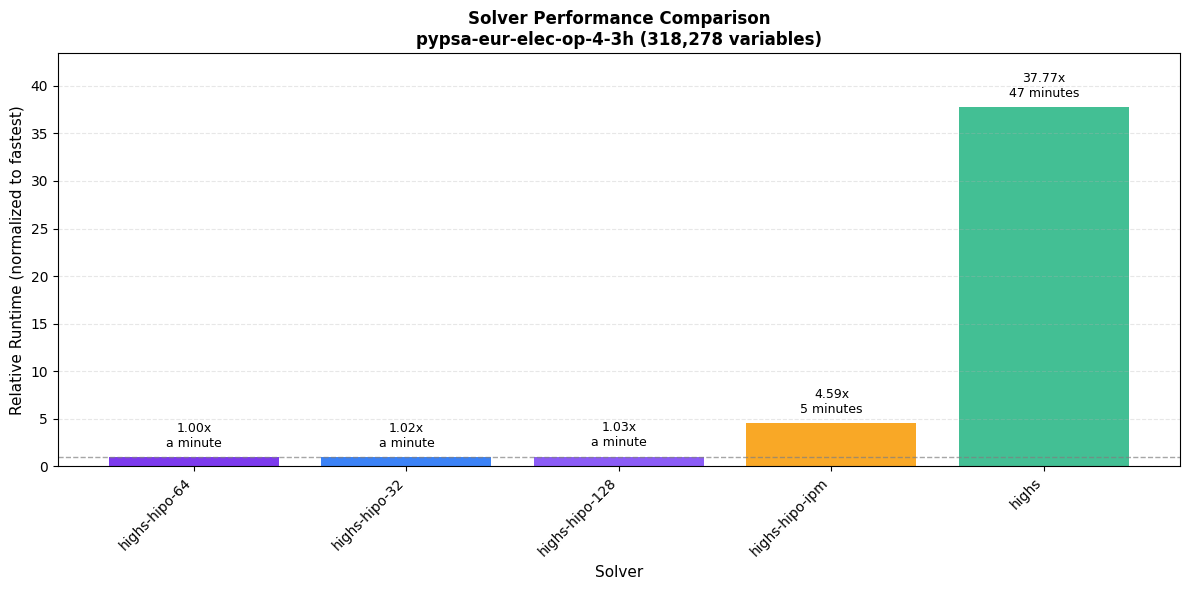


Benchmark: pypsa-eur-elec-op-6-24h - Variables: 58,841 (M)
Paper results - IPX (baseline): 24.5s, HiPO: 27.4s, Speedup: 0.89x
Our runtimes - highs-hipo-ipm: 24.5s, highs-1.10: 28.2s, Gurobi: 7.5s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.67x, Diff vs paper: +0.77x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.79x, Diff vs paper: +0.89x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.80x, Diff vs paper: +0.90x (better)


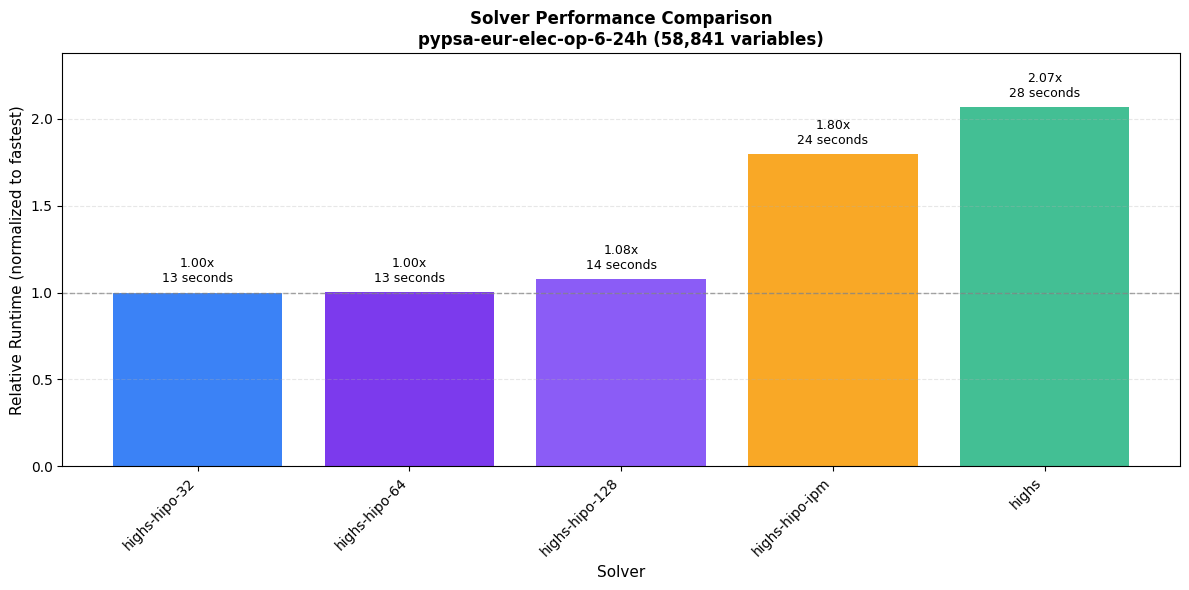


Benchmark: pypsa-eur-elec-op-8-12h - Variables: 152,656 (M)
Paper results - IPX (baseline): 164.5s, HiPO: 89.0s, Speedup: 1.85x
Our runtimes - highs-hipo-ipm: 127.2s, highs-1.10: 250.4s, Gurobi: 40.3s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.69x, Diff vs paper: -0.16x (worse)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.75x, Diff vs paper: -0.10x (worse)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.82x, Diff vs paper: -0.03x (worse)


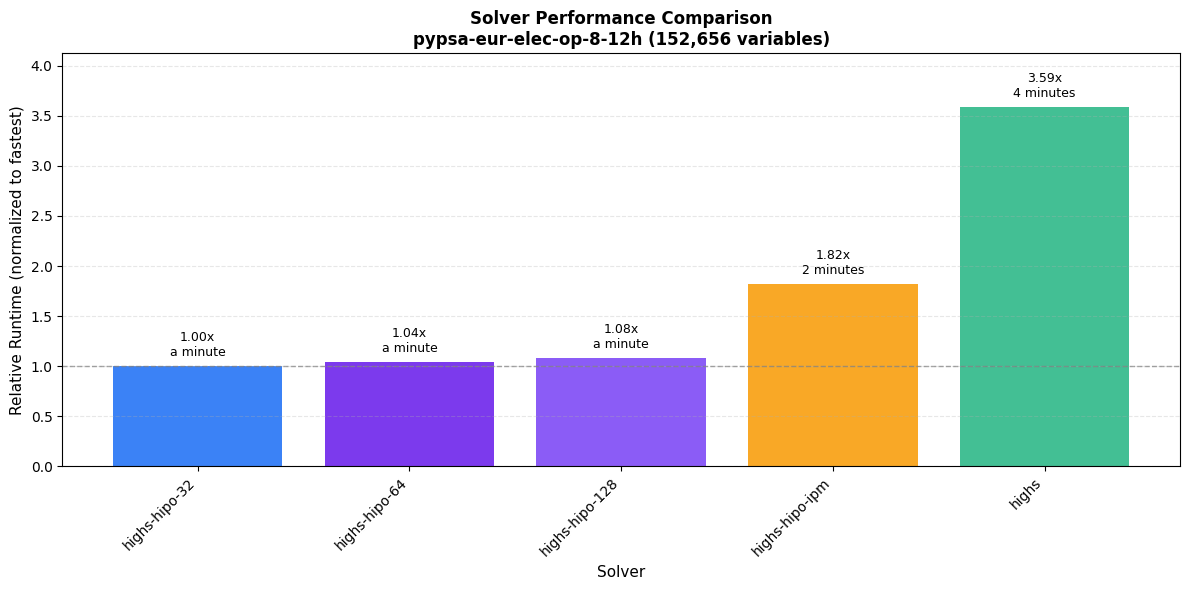


Benchmark: pypsa-eur-elec-trex-3-12h - Variables: 57,705 (M)
Paper results - IPX (baseline): 25.6s, HiPO: 39.9s, Speedup: 0.64x
Our runtimes - highs-hipo-ipm: 25.7s, highs-1.10: 21.0s, Gurobi: 7.8s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.38x, Diff vs paper: +0.74x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.55x, Diff vs paper: +0.90x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.92x (better)


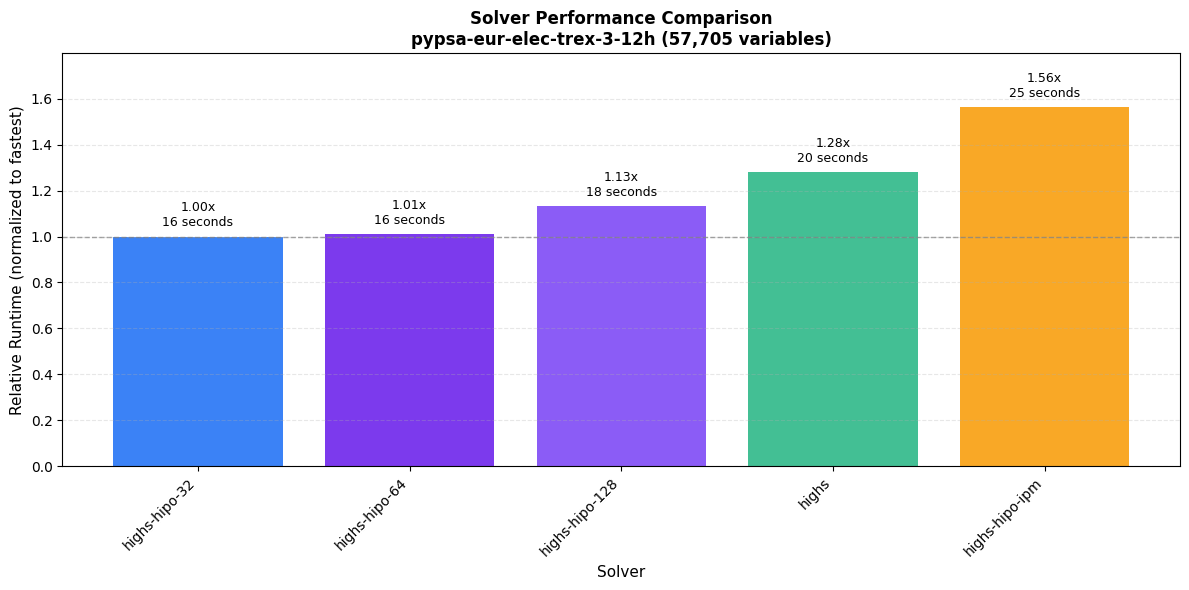


Benchmark: pypsa-eur-elec-trex-3-3h - Variables: 230,682 (M)
Paper results - IPX (baseline): 304.1s, HiPO: 87.4s, Speedup: 3.48x
Our runtimes - highs-hipo-ipm: 229.7s, highs-1.10: 881.1s, Gurobi: 33.9s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.88x, Diff vs paper: +0.40x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.45x, Diff vs paper: +0.97x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.98x, Diff vs paper: +0.50x (better)


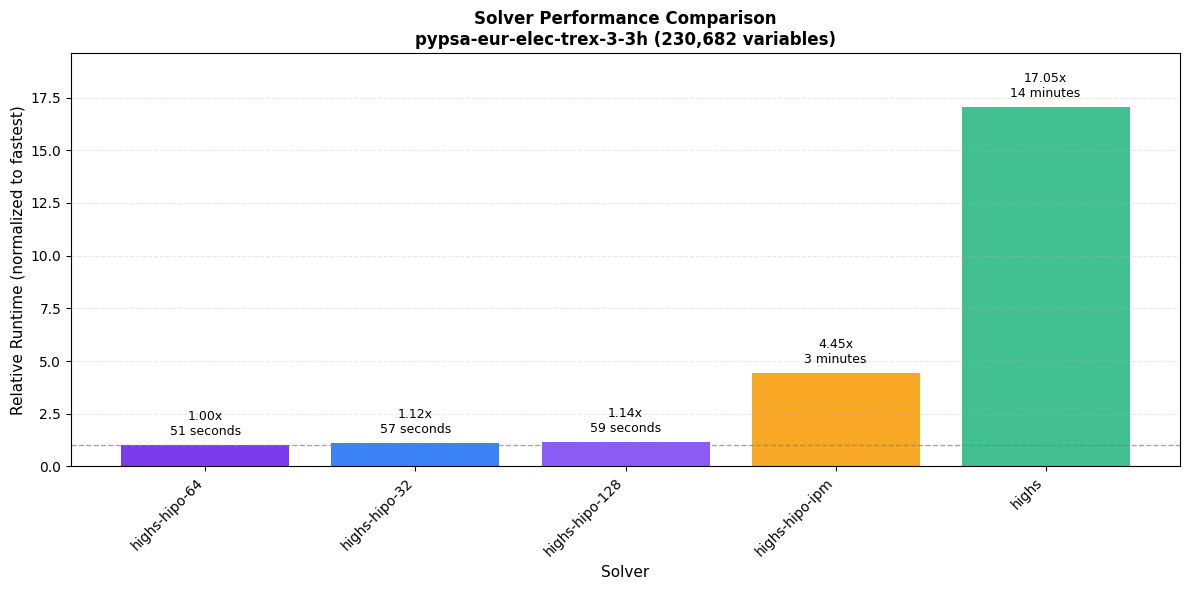


Benchmark: pypsa-eur-elec-trex-4-3h - Variables: 318,285 (M)
Paper results - IPX (baseline): 573.2s, HiPO: 131.1s, Speedup: 4.37x
Our runtimes - highs-hipo-ipm: 415.5s, highs-1.10: 3600.0s, Gurobi: 78.5s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 3.83x, Diff vs paper: -0.54x (worse)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 4.09x, Diff vs paper: -0.28x (worse)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 3.92x, Diff vs paper: -0.45x (worse)


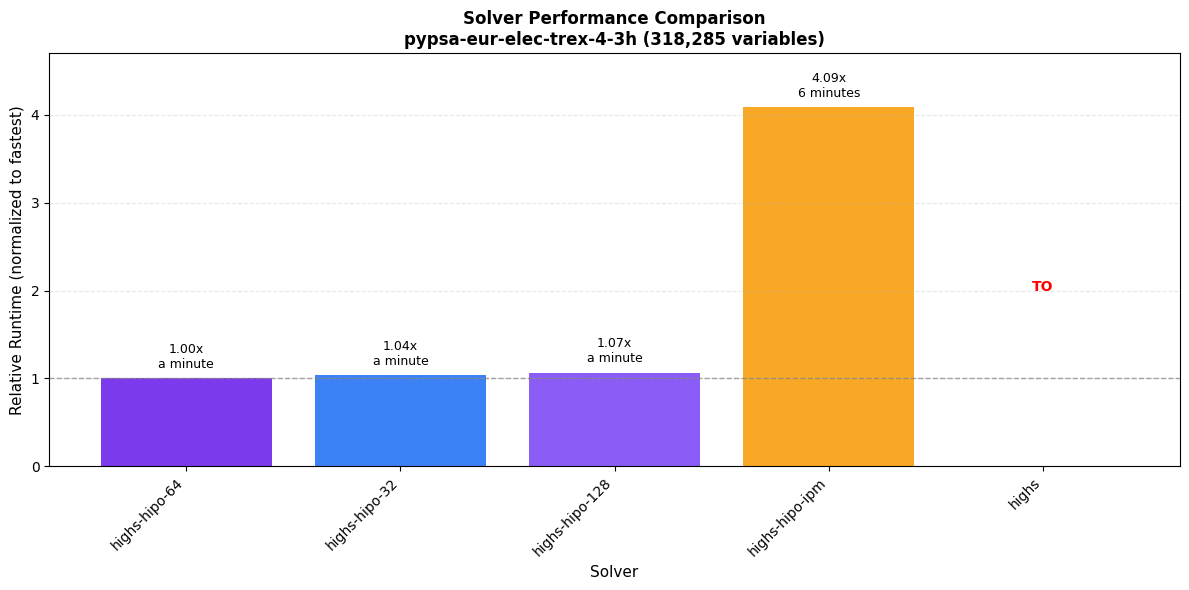


Benchmark: pypsa-eur-elec-trex-6-12h - Variables: 117,605 (M)
Paper results - IPX (baseline): 96.7s, HiPO: 78.4s, Speedup: 1.23x
Our runtimes - highs-hipo-ipm: 79.3s, highs-1.10: 184.7s, Gurobi: 27.5s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 2.02x, Diff vs paper: +0.78x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 2.05x, Diff vs paper: +0.82x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 2.10x, Diff vs paper: +0.87x (better)


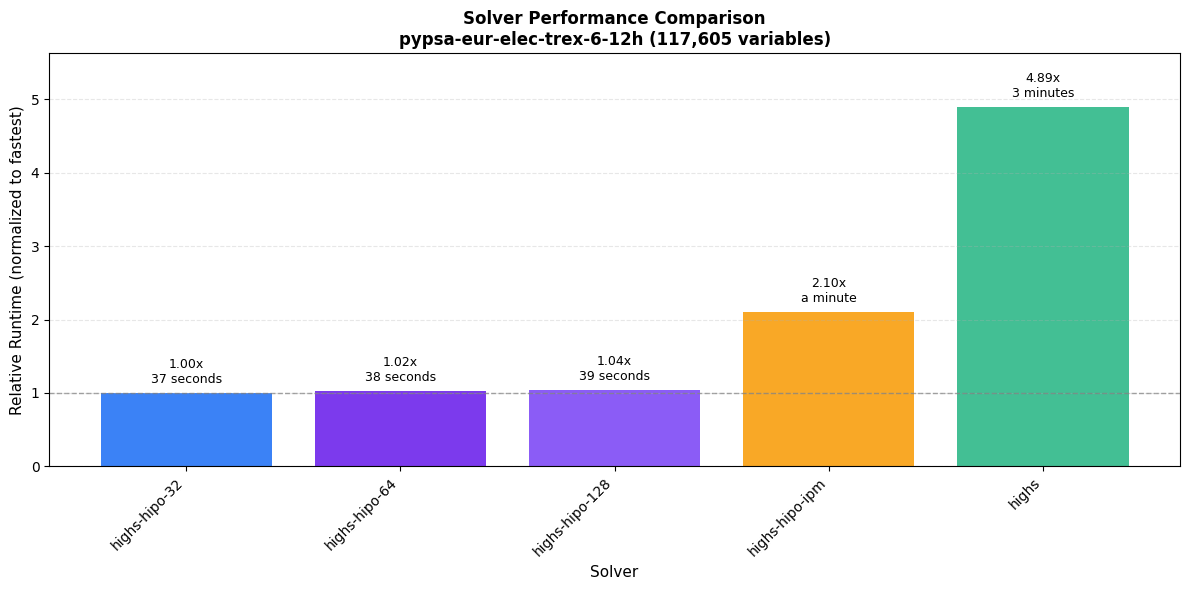


Benchmark: pypsa-eur-sec-2-24h - Variables: 63,264 (M)
Paper results - IPX (baseline): 37.9s, HiPO: 29.7s, Speedup: 1.28x
Our runtimes - highs-hipo-ipm: 31.9s, highs-1.10: 26.8s, Gurobi: 13.7s

Speedup of highs-hipo-128 vs highs-hipo-ipm: 1.34x, Diff vs paper: +0.06x (better)
Speedup of highs-hipo-64 vs highs-hipo-ipm: 1.56x, Diff vs paper: +0.29x (better)
Speedup of highs-hipo-32 vs highs-hipo-ipm: 1.47x, Diff vs paper: +0.19x (better)


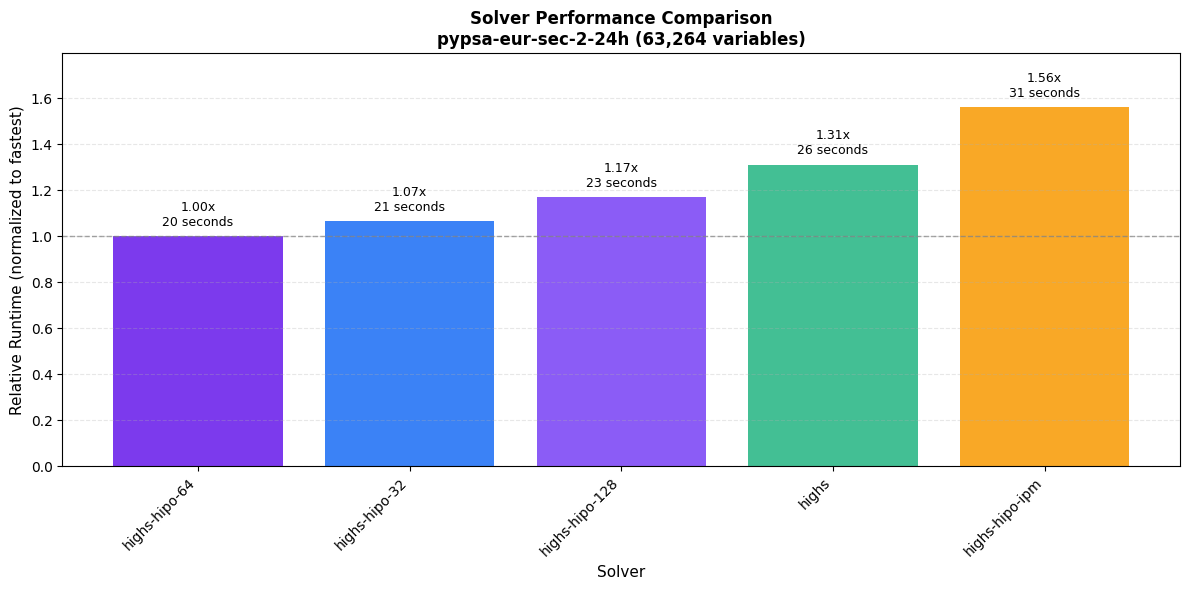

In [8]:
# Plot each benchmark individually with solvers on x-axis
print("\n" + "="*80)
print("COMPARISON WITH HIPO PAPER RESULTS")
print("="*80)

not_handled_paper_benchmarks = set(hipo_paper_results.keys())

# Build mapping: bench-size -> num_variables from metadata
var_counts = {}
var_size_labels = {}
for bench_name, bench_info in meta['benchmarks'].items():
    for size_info in bench_info.get('Sizes', []):
        size_name = size_info.get('Name')
        num_vars = size_info.get('Num. variables')
        size_label = size_info.get('Size')
        bench_size = f"{bench_name}-{size_name}"
        var_counts[bench_size] = num_vars
        var_size_labels[bench_size] = size_label

# Load Gurobi results from previous_results.csv for comparison
gurobi_results = pd.read_csv("../results/previous_results.csv")
gurobi_results = gurobi_results[
    (gurobi_results["Solver"] == "gurobi") &
    (gurobi_results["Status"] == "ok")
].copy()
# Ensure bench-size column exists
if "bench-size" not in gurobi_results.columns:
    gurobi_results["bench-size"] = gurobi_results["Benchmark"] + "-" + gurobi_results["Size"]
# Get most recent Gurobi version for each benchmark
gurobi_results = gurobi_results.sort_values("Solver Release Year").drop_duplicates("bench-size", keep="last")
gurobi_runtimes = dict(zip(gurobi_results["bench-size"], gurobi_results["Runtime (s)"]))



for bench in sorted(unique_benchmarks):
    # Check if we have paper results for this benchmark
    try:
        k = [b for b in hipo_paper_results.keys() if b in bench]
        if len(k) > 1:
            raise Exception("multiple keys match for bench:", bench, k)
        k = k[0]
        paper_data = hipo_paper_results[k]
        not_handled_paper_benchmarks.remove(k)
    except IndexError:
        # print("not found in paper results:", bench)
        continue

    print(f"\n{'='*80}")
    num_vars = var_counts.get(bench, "N/A")
    num_vars_str = f"{num_vars:,}" if isinstance(num_vars, int) else num_vars
    size_label = var_size_labels.get(bench, "N/A")
    print(f"Benchmark: {bench} - Variables: {num_vars_str} ({size_label})")
    print(f"Paper results - IPX (baseline): {paper_data['ipx_time']:.1f}s, HiPO: {paper_data['hipo_time']:.1f}s, Speedup: {paper_data['ipx_time']/paper_data['hipo_time']:.2f}x")

    # Get our results and augment with speedup columns
    bench_data = actual_benchmarks[actual_benchmarks['bench-size'] == bench].copy()

    # Get baseline times for speedup calculations
    highs_ipx_time = bench_data[bench_data['Solver'] == 'highs-hipo-ipm']['Runtime (s)'].values
    highs_110_time = bench_data[bench_data['Solver'] == 'highs']['Runtime (s)'].values

    # Get Gurobi runtime and print runtime comparison
    gurobi_runtime = gurobi_runtimes.get(bench, None)
    runtime_parts = []
    if len(highs_ipx_time) > 0:
        runtime_parts.append(f"highs-hipo-ipm: {highs_ipx_time[0]:.1f}s")
    if len(highs_110_time) > 0:
        runtime_parts.append(f"highs-1.10: {highs_110_time[0]:.1f}s")
    if gurobi_runtime:
        runtime_parts.append(f"Gurobi: {gurobi_runtime:.1f}s")
    if runtime_parts:
        print("Our runtimes - " + ", ".join(runtime_parts) + "\n")

    # Initialize speedup columns with NaN
    bench_data['speedup_vs_highs_ipx'] = float('nan')
    bench_data['speedup_vs_highs_110'] = float('nan')

    # Calculate speedups for each solver
    for idx in bench_data.index:
        solver_time = bench_data.loc[idx, 'Runtime (s)']

        # Speedup vs highs-hipo-ipm (IPX baseline)
        if len(highs_ipx_time) > 0 and highs_ipx_time[0] > 0 and solver_time > 0:
            bench_data.loc[idx, 'speedup_vs_highs_ipx'] = highs_ipx_time[0] / solver_time

        # Speedup vs highs (HiGHS 1.10)
        if len(highs_110_time) > 0 and highs_110_time[0] > 0 and solver_time > 0:
            bench_data.loc[idx, 'speedup_vs_highs_110'] = highs_110_time[0] / solver_time

    # Compare speedups for HiGHS HiPO variants
    paper_speedup = paper_data['ipx_time'] / paper_data['hipo_time']

    highs_hipo_variants = ['highs-hipo-128', 'highs-hipo-64', 'highs-hipo-32']
    for variant in highs_hipo_variants:
        variant_data = bench_data[bench_data['Solver'] == variant]
        if not variant_data.empty:
            speedup_ipx = variant_data['speedup_vs_highs_ipx'].values[0]

            if not pd.isna(speedup_ipx):
                speedup_diff = speedup_ipx - paper_speedup
                print(f"Speedup of {variant} vs highs-hipo-ipm: {speedup_ipx:.2f}x, Diff vs paper: {speedup_diff:+.2f}x ({'better' if speedup_diff > 0 else 'worse'})")
            else:
                print(f"  - Missing data for variant {variant}, cannot compute speedup.")

    print(f"{'='*80}")
    plot_single_benchmark_comparison(results, bench, num_vars=num_vars, figsize=(12, 6))
    plt.show()

if not_handled_paper_benchmarks:
    print(f"Warning: Some paper benchmarks not found in results: {not_handled_paper_benchmarks}")
    not_handled_paper_benchmarks.clear()
else:
    print("All paper benchmarks accounted for.")

## Performance Statistics

Found 118 PyPSA benchmark results
var_counts for {}
highs               : ω = 2.62 (R² = 0.705)
highs-hipo-ipm      : ω = 1.75 (R² = 0.759)
highs-hipo-32       : ω = 1.40 (R² = 0.489)
highs-hipo-64       : ω = 1.39 (R² = 0.487)
highs-hipo-128      : ω = 1.39 (R² = 0.483)


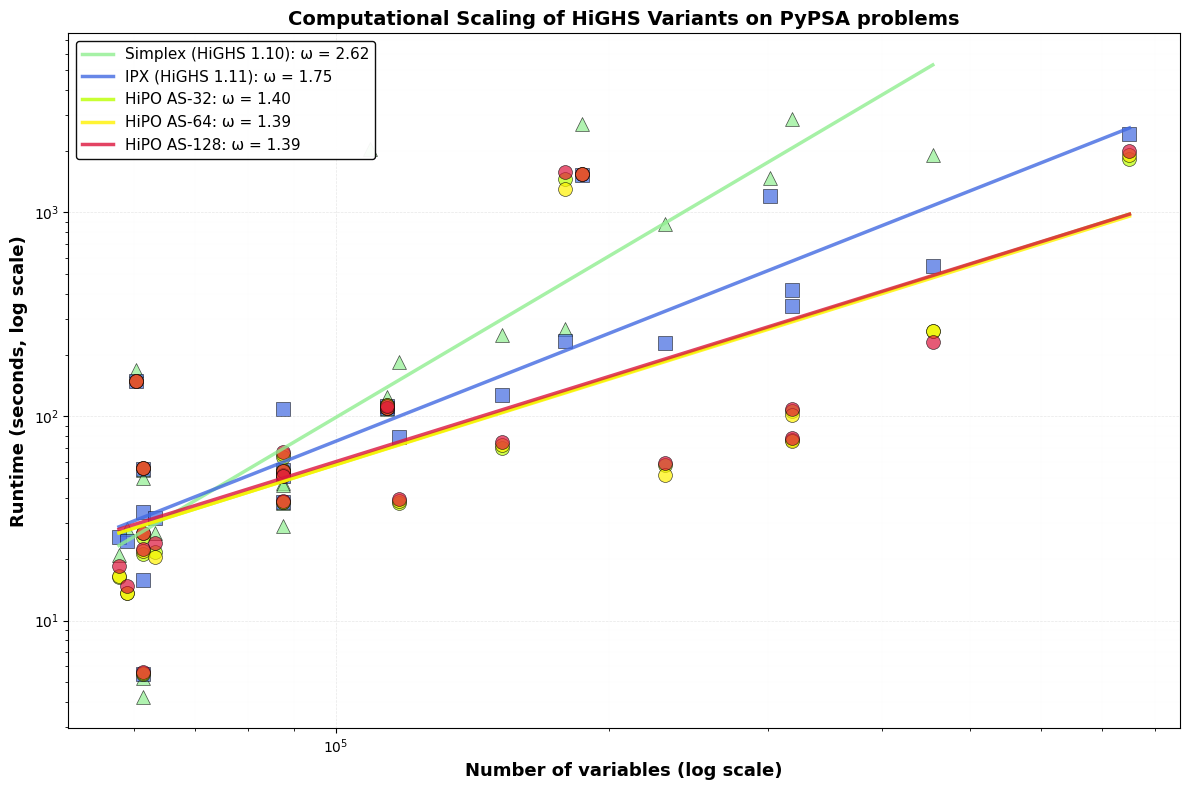

In [9]:
# Logarithmic Scaling Analysis (like HiPO Paper Figure 5)
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterMathtext, LogLocator
import numpy as np
import pandas as pd
from scipy import stats
import yaml

# Filter to PyPSA benchmarks only
benchmarks_to_plot = actual_benchmarks[
    (actual_benchmarks['Benchmark'].str.contains('pypsa', case=False, na=False)) &
    (actual_benchmarks['Status'] == 'ok')
].copy()
# pypsa_benchmarks = actual_benchmarks[
#     actual_benchmarks['Status'] == 'ok'
# ].copy()

print(f"Found {len(benchmarks_to_plot)} PyPSA benchmark results")

# Load metadata to get number of variables
with open('../results/metadata.yaml') as f:
    meta = yaml.safe_load(f)

# Build mapping: bench-size -> num_variables
var_counts = {}
for bench_name, bench_info in meta['benchmarks'].items():
    for size_info in bench_info.get('Sizes', []):
        size_name = size_info.get('Name')
        num_vars = size_info.get('Num. variables')
        if size_name and num_vars:
            bench_size = f"{bench_name}-{size_name}"
            var_counts[bench_size] = num_vars
        else:
            print("skipping {bench_name}-{size_name}")


print("var_counts for {}")

# Solvers to plot
solvers_to_plot = ['highs', 'highs-hipo-ipm', 'highs-hipo-32', 'highs-hipo-64', 'highs-hipo-128']
# solvers_to_plot = ['highs-hipo-ipm', 'highs-hipo-128']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = {
    'highs': '#90EE90',  # light green (simplex)
    'highs-hipo-ipm': '#4169E1',  # royal blue (IPX)
    'highs-hipo-32': "#BBFF00",  # crimson (HiPO AS)
    'highs-hipo-64': "#FFF200",
    'highs-hipo-128': '#DC143C',
}

markers = {
    'highs': '^',  # triangle
    'highs-hipo-ipm': 's',  # square
    'highs-hipo-32': 'o',  # circle
    'highs-hipo-64': 'o',
    'highs-hipo-128': 'o',
}

labels = {
    'highs': 'Simplex (HiGHS 1.10)',
    'highs-hipo-ipm': 'IPX (HiGHS 1.11)',
    'highs-hipo-32': 'HiPO AS-32',
    'highs-hipo-64': 'HiPO AS-64',
    'highs-hipo-128': 'HiPO AS-128',
}

# For each solver
for solver in solvers_to_plot:
    solver_data = benchmarks_to_plot[
        (benchmarks_to_plot['Solver'] == solver) &
        (benchmarks_to_plot['Status'] == 'ok')
    ].copy()

    if len(solver_data) == 0:
        print(f"No data for {solver}")
        continue

    # Add variable counts
    solver_data['num_vars'] = solver_data['bench-size'].map(var_counts)
    solver_data = solver_data.dropna(subset=['num_vars'])

    if len(solver_data) == 0:
        print(f"No variable counts for {solver}")
        continue

    solver_data = solver_data.sort_values('num_vars')

    x_values = solver_data['num_vars'].values
    y_values = solver_data['Runtime (s)'].values

    # Plot scatter points
    ax.scatter(
        x_values,
        y_values,
        color=colors.get(solver, 'gray'),
        marker=markers.get(solver, 'o'),
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5,
    )

    # Fit power law: y = a * x^omega
    # On log-log scale: log(y) = log(a) + omega * log(x)
    if len(x_values) > 3:
        log_x = np.log10(x_values)
        log_y = np.log10(y_values)
        slope, intercept, r_value, _, _ = stats.linregress(log_x, log_y)
        omega = slope

        # Plot fitted line
        x_fit = np.logspace(np.log10(x_values.min()), np.log10(x_values.max()), 100)
        y_fit = 10**(intercept) * x_fit**omega

        ax.plot(
            x_fit,
            y_fit,
            color=colors.get(solver, 'gray'),
            linestyle='-',
            alpha=0.8,
            linewidth=2.5,
            label=f'{labels.get(solver, solver)}: ω = {omega:.2f}'
        )

        print(f"{solver:20s}: ω = {omega:.2f} (R² = {r_value**2:.3f})")

# Set logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and formatting
ax.set_xlabel('Number of variables (log scale)', fontsize=13, weight='bold')
ax.set_ylabel('Runtime (seconds, log scale)', fontsize=13, weight='bold')
ax.set_title('Computational Scaling of HiGHS Variants on PyPSA problems',
             fontsize=14, weight='bold')

ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))

# Add minor ticks
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
# Grid
ax.grid(True, which='both', alpha=0.3, linestyle='--', linewidth=0.5)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3)

# Legend
ax.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='black')

# ax.set_xlim(1e4, 1e6)
# ax.set_ylim(0.1, 1e4)

# FIX: Explicitly set tick locators for consistent ticks (NO LIMITS NEEDED)
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))

# Use math text formatter for nice 10^x labels
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_major_formatter(LogFormatterMathtext())

plt.tight_layout()
plt.show()

# Scaling by model framework

In [10]:
# Logarithmic Scaling Analysis (like HiPO Paper Figure 5)
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterMathtext, LogLocator
import numpy as np
import pandas as pd
from scipy import stats
import yaml

# Filter to PyPSA benchmarks only
benchmarks_to_plot = actual_benchmarks[
    # (actual_benchmarks['Benchmark'].str.contains('pypsa', case=False, na=False)) &
    (actual_benchmarks['Status'] == 'ok')
].copy()
# pypsa_benchmarks = actual_benchmarks[
#     actual_benchmarks['Status'] == 'ok'
# ].copy()

# add model framework column to benchmarks to plot
# benchmarks_to_plot['Model Framework'] = benchmarks_to_plot['Benchmark'].str.split('-').str[0]
# # benchmarks_to_plot.head()
# unique_frameworks = benchmarks_to_plot['Model Framework'].unique()
# print(unique_frameworks)


In [11]:

from pyexpat import model


print(f"Found {len(benchmarks_to_plot)} PyPSA benchmark results")

# Load metadata to get number of variables
with open('../results/metadata.yaml') as f:
    meta = yaml.safe_load(f)

# Build mapping: bench-size -> num_variables
var_counts = {}
model_frameworks_from_meta = set()
for bench_name, bench_info in meta['benchmarks'].items():
    for size_info in bench_info.get('Sizes', []):
        size_name = size_info.get('Name')
        num_vars = size_info.get('Num. variables')
        if size_name and num_vars:
            bench_size = f"{bench_name}-{size_name}"
            var_counts[bench_size] = num_vars
        else:
            print("skipping {bench_name}-{size_name}")
    model_frameworks_from_meta.add(bench_info.get('Modelling framework', ''))

print(model_frameworks_from_meta)
# match results_to_plot benchmark names against model_frameworks and add that to the results. Point out rows where modelling framework could not be identified

def get_modelling_framework(benchmark_name):
    for model_framework in model_frameworks_from_meta:
        if model_framework.lower() in benchmark_name.lower():
            return model_framework
    return 'Unknown'

def get_modelling_framework_from_meta(benchmark_name):
    return meta['benchmarks'].get(benchmark_name, {}).get('Modelling framework', 'Unknown')

benchmarks_to_plot['Modelling framework'] = benchmarks_to_plot['Benchmark'].map(lambda x: get_modelling_framework_from_meta(x))

# Point out rows where modelling framework could not be identified
unknown_frameworks = benchmarks_to_plot[benchmarks_to_plot['Modelling framework'] == 'Unknown']

# unknown_frameworks.head()
# filter out rows with unknown modelling framework
benchmarks_to_plot = benchmarks_to_plot[benchmarks_to_plot['Modelling framework'] != 'Unknown']
unique_frameworks_from_results = benchmarks_to_plot['Modelling framework'].unique()

if (missing_frameworks := model_frameworks_from_meta - set(unique_frameworks_from_results)):
    print(f"missing frameworks in results {missing_frameworks}")


Found 417 PyPSA benchmark results
{'PowerModels', 'Tulipa', 'TEMOA', 'Sienna', 'TIMES', 'PyPSA', 'DCOPF', 'GenX'}


In [12]:

# Solvers to plot
solvers_to_plot = ['highs', 'highs-hipo-ipm', 'highs-hipo-32', 'highs-hipo-64', 'highs-hipo-128']

colors = {
    'highs': '#90EE90',  # light green (simplex)
    'highs-hipo-ipm': '#4169E1',  # royal blue (IPX)
    'highs-hipo-32': "#BBFF00",  # crimson (HiPO AS)
    'highs-hipo-64': "#FFF200",
    'highs-hipo-128': '#DC143C',
}

markers = {
    'highs': '^',  # triangle
    'highs-hipo-ipm': 's',  # square
    'highs-hipo-32': 'o',  # circle
    'highs-hipo-64': 'o',
    'highs-hipo-128': 'o',
}

labels = {
    'highs': 'Simplex (HiGHS 1.10)',
    'highs-hipo-ipm': 'IPX (HiGHS 1.11)',
    'highs-hipo-32': 'HiPO AS-32',
    'highs-hipo-64': 'HiPO AS-64',
    'highs-hipo-128': 'HiPO AS-128',
}


highs               : ω = 2.15 (R² = 0.963)
highs-hipo-ipm      : ω = 1.59 (R² = 0.874)
highs-hipo-32       : ω = 1.52 (R² = 0.866)
highs-hipo-64       : ω = 1.51 (R² = 0.862)
highs-hipo-128      : ω = 1.59 (R² = 0.884)


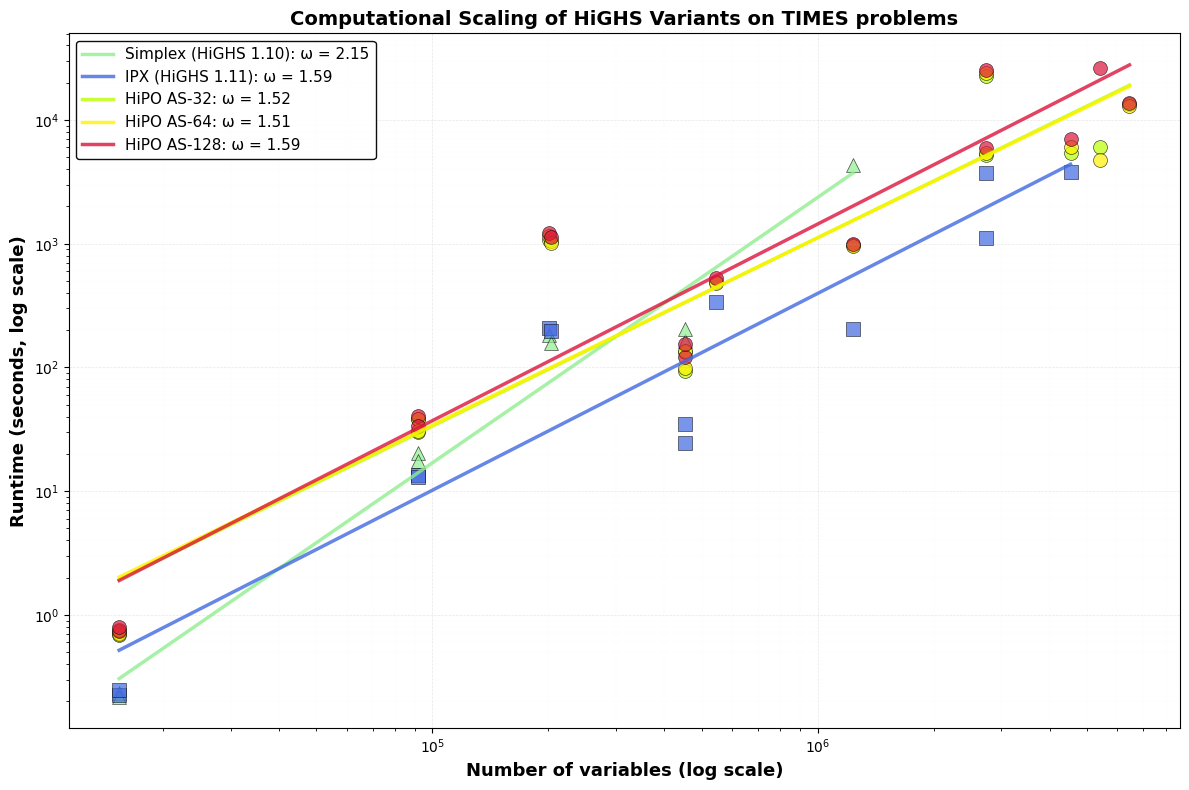

highs               : ω = 1.88 (R² = 0.998)
highs-hipo-ipm      : ω = 1.57 (R² = 0.996)
highs-hipo-32       : ω = 1.44 (R² = 0.987)
highs-hipo-64       : ω = 1.44 (R² = 0.984)
highs-hipo-128      : ω = 1.48 (R² = 0.994)


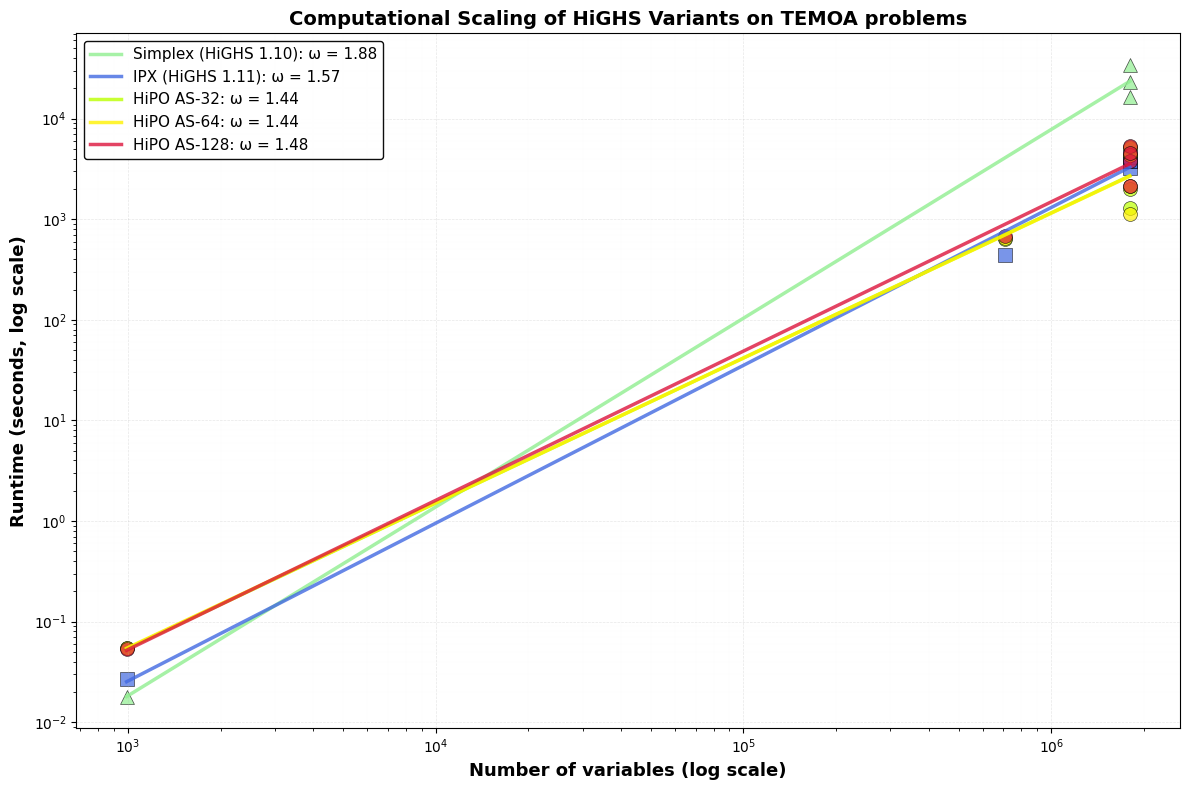

highs               : ω = 3.52 (R² = 0.783)
highs-hipo-ipm      : ω = 3.34 (R² = 0.672)
highs-hipo-32       : ω = 3.34 (R² = 0.674)
highs-hipo-64       : ω = 3.36 (R² = 0.677)
highs-hipo-128      : ω = 3.35 (R² = 0.674)


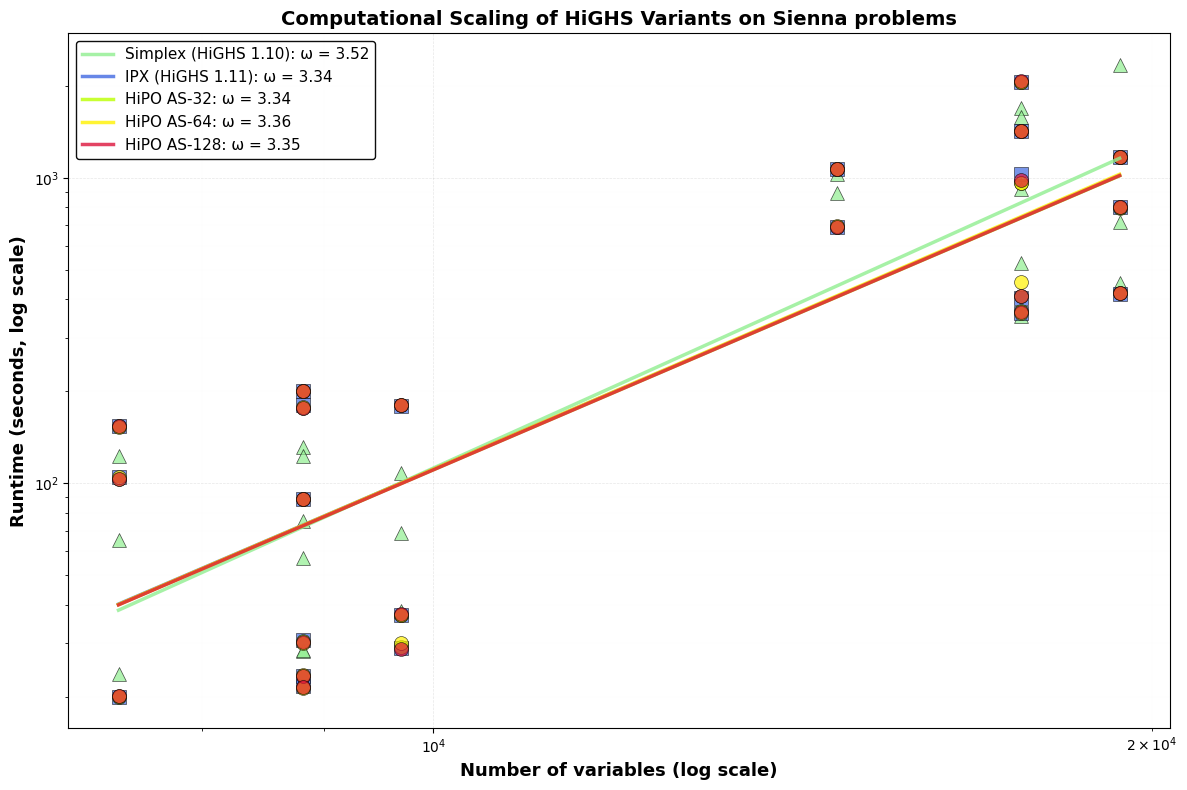

highs               : ω = 2.62 (R² = 0.705)
highs-hipo-ipm      : ω = 1.75 (R² = 0.759)
highs-hipo-32       : ω = 1.40 (R² = 0.489)
highs-hipo-64       : ω = 1.39 (R² = 0.487)
highs-hipo-128      : ω = 1.39 (R² = 0.483)


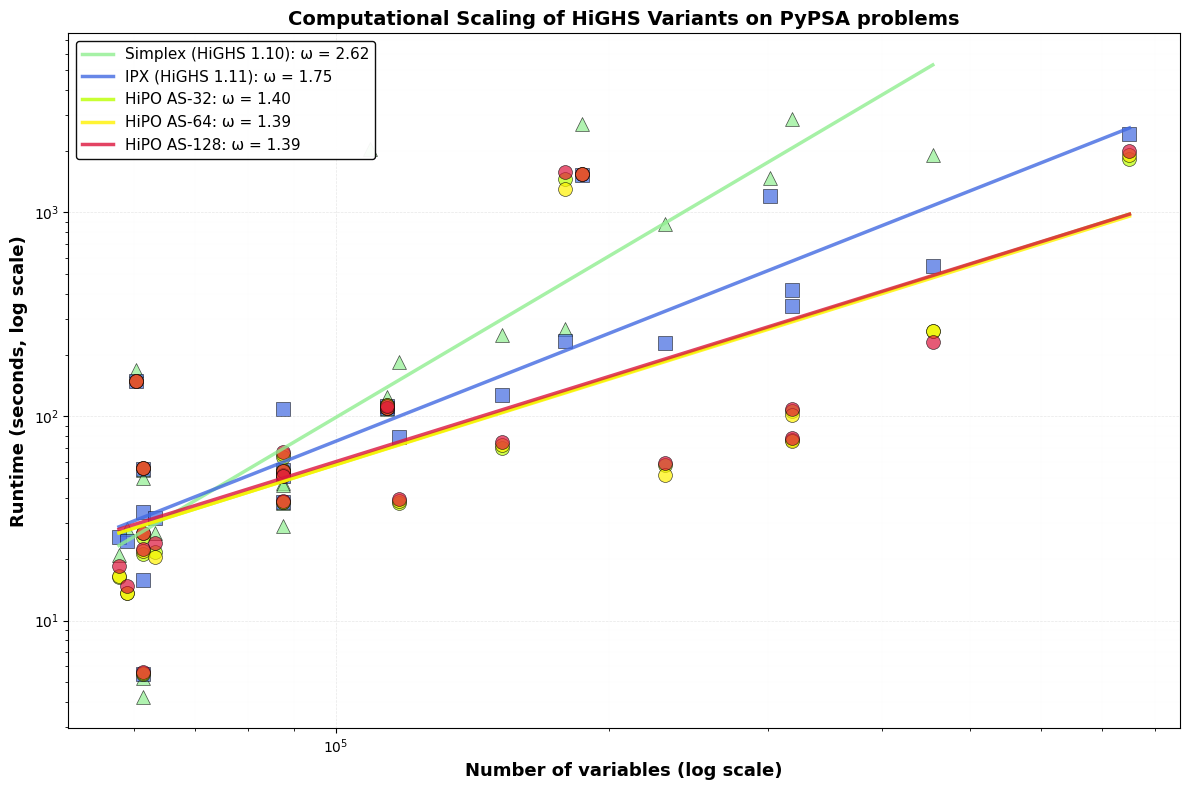

highs               : ω = 2.22 (R² = 0.905)
highs-hipo-ipm      : ω = 2.08 (R² = 0.791)
highs-hipo-32       : ω = 1.98 (R² = 0.679)
highs-hipo-64       : ω = 1.98 (R² = 0.679)
highs-hipo-128      : ω = 1.48 (R² = 0.763)


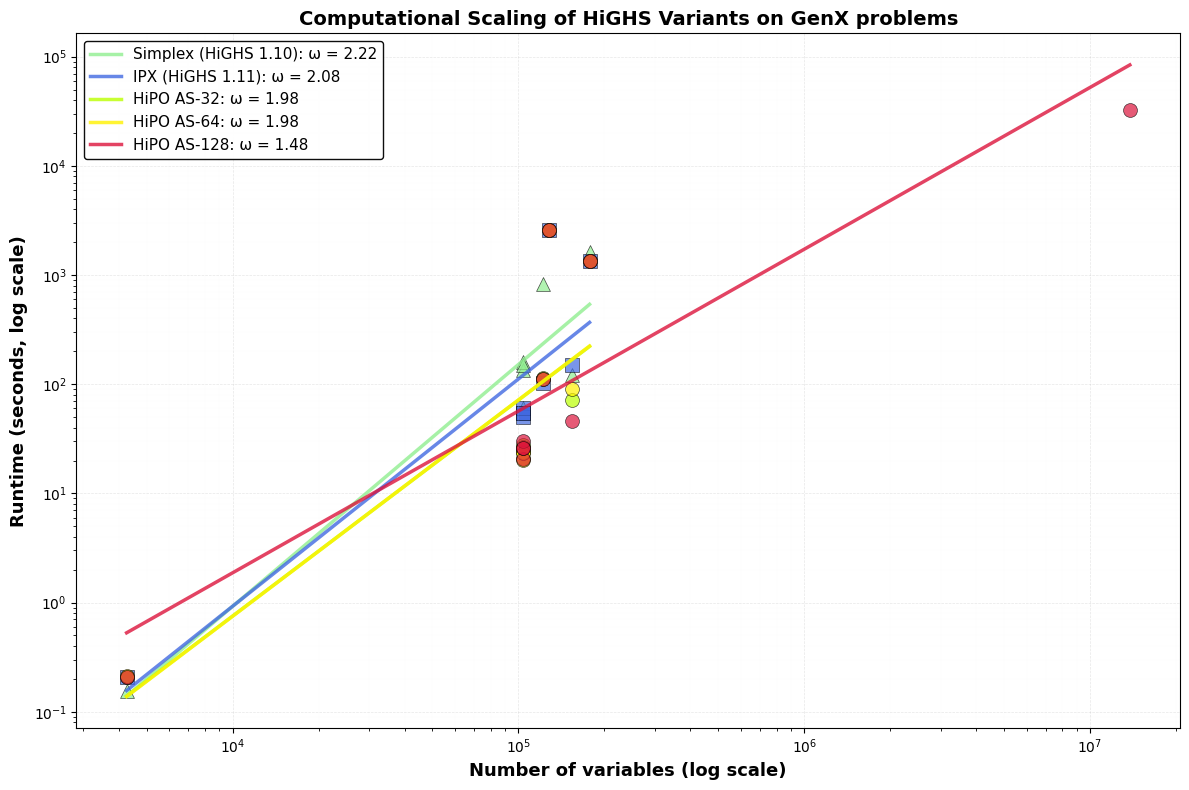

highs               : ω = 1.22 (R² = 0.920)
highs-hipo-ipm      : ω = 1.07 (R² = 0.987)
highs-hipo-32       : ω = 1.07 (R² = 0.986)
highs-hipo-64       : ω = 1.07 (R² = 0.986)
highs-hipo-128      : ω = 1.07 (R² = 0.986)


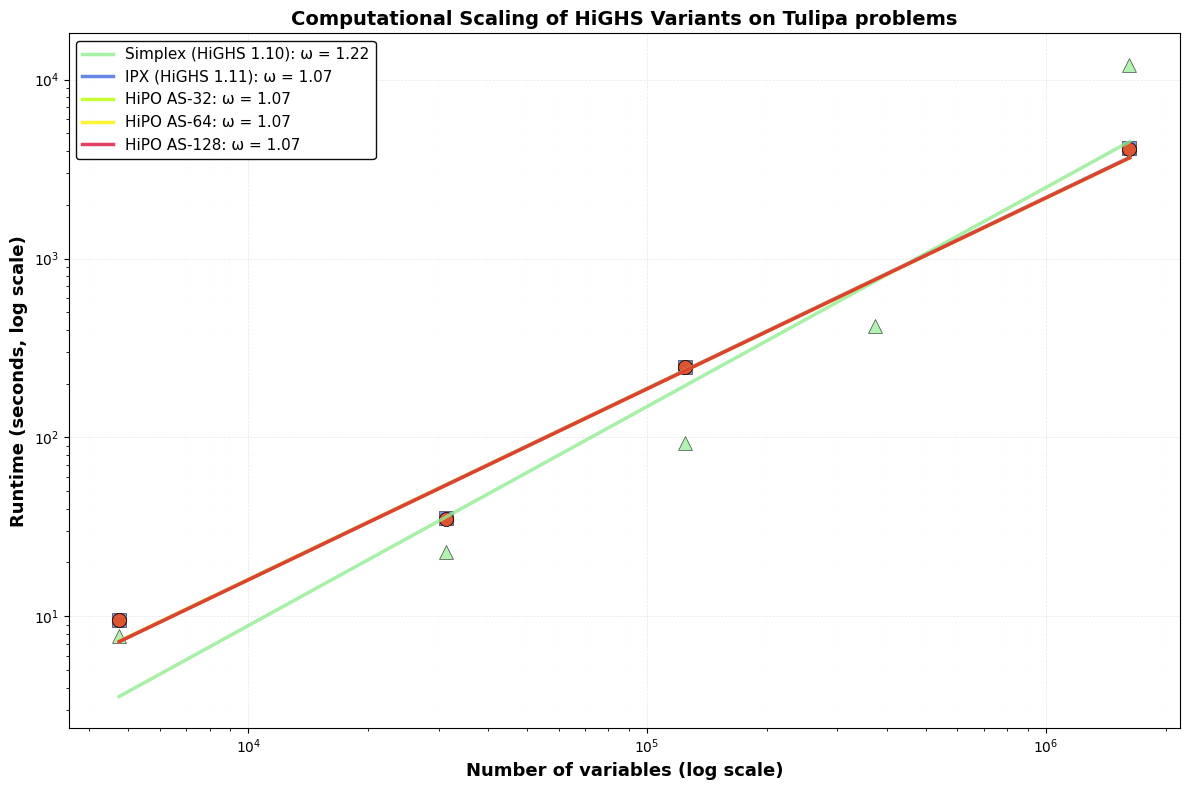

highs               : ω = 72.94 (R² = 1.000)
highs-hipo-ipm      : ω = 69.78 (R² = 1.000)
highs-hipo-32       : ω = 68.34 (R² = 0.997)
highs-hipo-64       : ω = 60.22 (R² = 0.996)
highs-hipo-128      : ω = 60.18 (R² = 0.996)


/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: overflow encountered in power
  y_fit = 10**(intercept) * x_fit**omega
/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: invalid value encountered in multiply
  y_fit = 10**(intercept) * x_fit**omega
/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: overflow encountered in power
  y_fit = 10**(intercept) * x_fit**omega
/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: invalid value encountered in multiply
  y_fit = 10**(intercept) * x_fit**omega
/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: overflow encountered in power
  y_fit = 10**(intercept) * x_fit**omega
/tmp/ipykernel_819585/2031477455.py:50: RuntimeWarning: invalid value encountered in multiply
  y_fit = 10**(intercept) * x_fit**omega


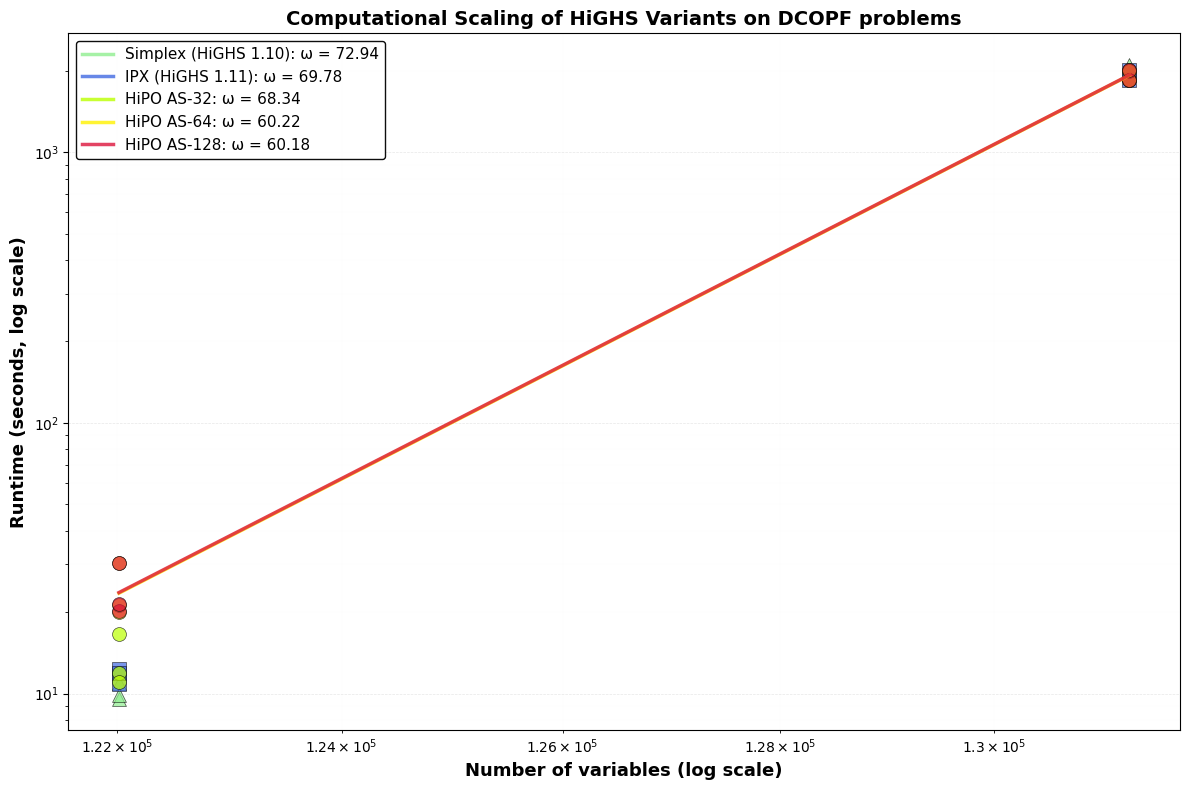

/tmp/ipykernel_819585/2031477455.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='black')


No data for highs


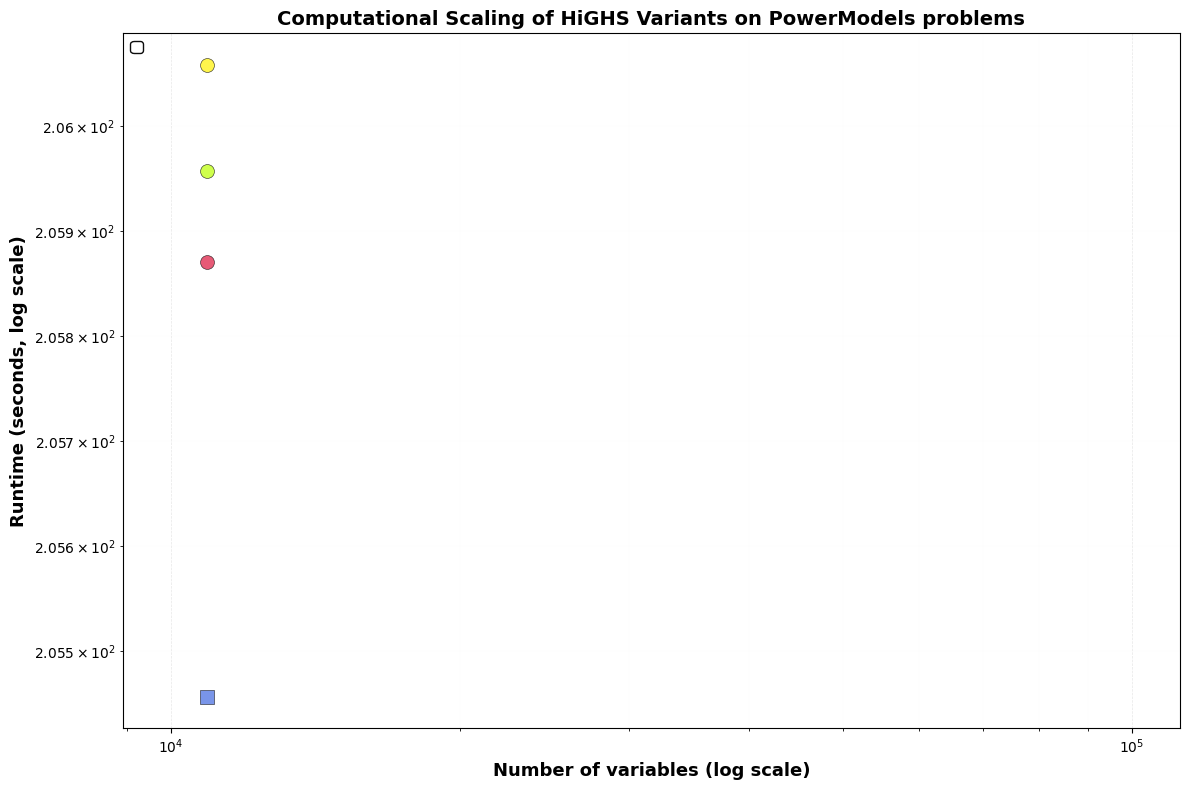

In [13]:
# Create the plots
for framework in unique_frameworks_from_results:
    fig, ax = plt.subplots(figsize=(12, 8))
    for solver in solvers_to_plot:
        solver_data = benchmarks_to_plot[
            (benchmarks_to_plot['Solver'] == solver) &
            (benchmarks_to_plot['Status'] == 'ok') &
            (benchmarks_to_plot['Modelling framework'] == framework)
        ].copy()

        if len(solver_data) == 0:
            print(f"No data for {solver}")
            continue

        # Add variable counts
        solver_data['num_vars'] = solver_data['bench-size'].map(var_counts)
        solver_data = solver_data.dropna(subset=['num_vars'])

        if len(solver_data) == 0:
            print(f"No variable counts for {solver}")
            continue

        solver_data = solver_data.sort_values('num_vars')

        x_values = solver_data['num_vars'].values
        y_values = solver_data['Runtime (s)'].values

        # Plot scatter points
        ax.scatter(
            x_values,
            y_values,
            color=colors.get(solver, 'gray'),
            marker=markers.get(solver, 'o'),
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5,
        )

        # Fit power law: y = a * x^omega
        # On log-log scale: log(y) = log(a) + omega * log(x)
        if len(x_values) > 3:
            log_x = np.log10(x_values)
            log_y = np.log10(y_values)
            slope, intercept, r_value, _, _ = stats.linregress(log_x, log_y)
            omega = slope

            # Plot fitted line
            x_fit = np.logspace(np.log10(x_values.min()), np.log10(x_values.max()), 100)
            y_fit = 10**(intercept) * x_fit**omega

            ax.plot(
                x_fit,
                y_fit,
                color=colors.get(solver, 'gray'),
                linestyle='-',
                alpha=0.8,
                linewidth=2.5,
                label=f'{labels.get(solver, solver)}: ω = {omega:.2f}'
            )

            print(f"{solver:20s}: ω = {omega:.2f} (R² = {r_value**2:.3f})")

    # Set logarithmic scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Labels and formatting
    ax.set_xlabel('Number of variables (log scale)', fontsize=13, weight='bold')
    ax.set_ylabel('Runtime (seconds, log scale)', fontsize=13, weight='bold')
    ax.set_title(f'Computational Scaling of HiGHS Variants on {framework} problems',
                fontsize=14, weight='bold')

    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))

    # Add minor ticks
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
    # Grid
    ax.grid(True, which='both', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3)

    # Legend
    ax.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='black')

    # ax.set_xlim(1e4, 1e6)
    # ax.set_ylim(0.1, 1e4)

    # FIX: Explicitly set tick locators for consistent ticks (NO LIMITS NEEDED)
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))

    # Use math text formatter for nice 10^x labels
    ax.xaxis.set_major_formatter(formatter=LogFormatterMathtext())
    ax.yaxis.set_major_formatter(LogFormatterMathtext())

    plt.tight_layout()
    plt.show()

In [14]:
# Calculate speedup statistics for each variant compared to baseline highs
baseline_solver = "highs"

# Get baseline runtimes for each benchmark
baseline_data = actual_benchmarks[actual_benchmarks["Solver"] == baseline_solver][
    ["bench-size", "Runtime (s)"]
].rename(columns={"Runtime (s)": "Baseline Runtime"})

# Merge with all results
comparison = actual_benchmarks.merge(baseline_data, on="bench-size", how="left")

# Calculate speedup
comparison["Speedup"] = comparison["Baseline Runtime"] / comparison["Runtime (s)"]

# Summary statistics by solver
speedup_summary = (
    comparison.groupby("Solver")["Speedup"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(3)
)

print("Speedup Statistics (relative to highs 1.10.0):")
print(speedup_summary)

Speedup Statistics (relative to highs 1.10.0):
                 mean  median    min      max     std
Solver                                               
highs           1.000     1.0  1.000    1.000   0.000
highs-hipo-128  4.271     1.0  0.002  184.700  17.531
highs-hipo-32   4.302     1.0  0.006  172.432  16.495
highs-hipo-64   4.318     1.0  0.006  170.458  16.383
highs-hipo-ipm  2.557     1.0  0.002   32.392   4.312


## Memory Usage Comparison

In [15]:
# Memory usage comparison
memory_summary = (
    actual_benchmarks.groupby("Solver")["Memory Usage (MB)"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(2)
)

print("Memory Usage Statistics (MB):")
print(memory_summary)

Memory Usage Statistics (MB):
                   mean   median     min       max       std
Solver                                                      
highs           7435.66  1115.13  144.15  59533.26  15627.88
highs-hipo-128  5561.42   340.83  136.64  59458.07  14280.38
highs-hipo-32   4633.12   337.64  136.24  59455.98  13177.26
highs-hipo-64   4632.96   339.14  136.46  59456.48  13175.97
highs-hipo-ipm  3786.69   227.22  136.27  59442.45  12871.47


## Runtime vs Memory Trade-off

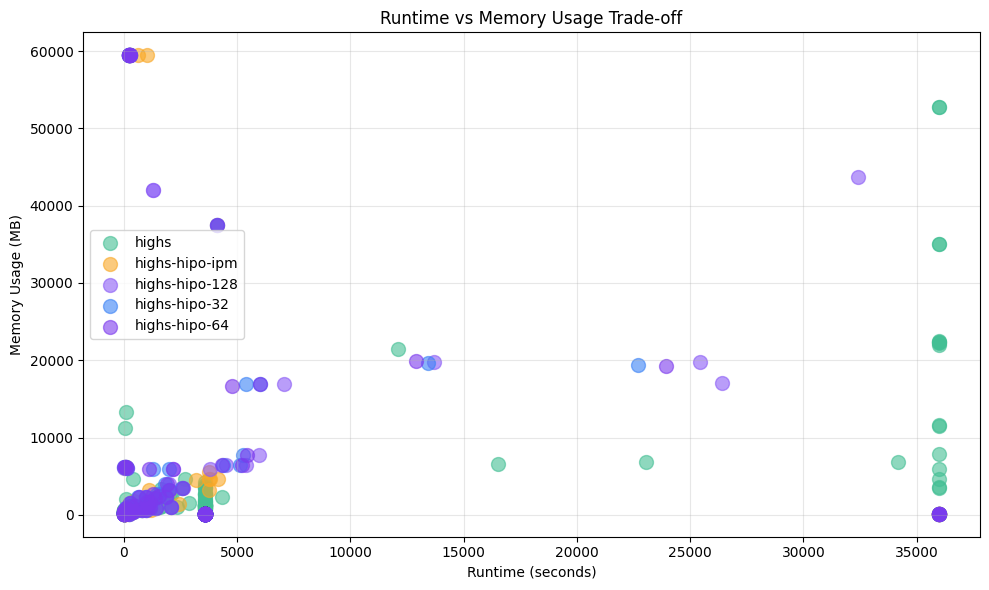

In [16]:
# Scatter plot: runtime vs memory usage
fig, ax = plt.subplots(figsize=(10, 6))

for solver in actual_benchmarks["Solver"].unique():
    solver_data = actual_benchmarks[actual_benchmarks["Solver"] == solver]
    ax.scatter(
        solver_data["Runtime (s)"],
        solver_data["Memory Usage (MB)"],
        label=solver,
        alpha=0.6,
        s=100,
        color=color_map.get(solver, "#888888"),
    )

ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("Memory Usage (MB)")
ax.set_title("Runtime vs Memory Usage Trade-off")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Benchmark-by-Benchmark Analysis

In [17]:
# For each benchmark, show detailed comparison
for bench in sorted(unique_benchmarks):
    bench_data = actual_benchmarks[actual_benchmarks["bench-size"] == bench]

    print(f"\n{'=' * 80}")
    print(f"Benchmark: {bench}")
    print(f"{'=' * 80}")

    # Create summary table
    summary = bench_data[["Solver", "Runtime (s)", "Memory Usage (MB)", "Status"]].copy()
    summary = summary.sort_values("Runtime (s)")

    # Calculate speedup relative to baseline
    baseline_runtime = bench_data[bench_data["Solver"] == baseline_solver][
        "Runtime (s)"
    ].values
    if len(baseline_runtime) > 0:
        summary["Speedup vs highs"] = baseline_runtime[0] / summary["Runtime (s)"]
        summary["Speedup vs highs"] = summary["Speedup vs highs"].round(3)

    print(summary.to_string(index=False))
    print()


Benchmark: DCOPF-Carolinas_1W-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs     9.580801            624.612     ok             1.000
highs-hipo-ipm    10.867961            280.208     ok             0.882
 highs-hipo-32    16.550848            338.920     ok             0.579
highs-hipo-128    30.337095            341.236     ok             0.316
 highs-hipo-64    30.387234            342.176     ok             0.315


Benchmark: DCOPF-Carolinas_2M-1-997
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
         highs    10.932277            621.916     ok             1.000
 highs-hipo-32    11.936978            338.400     ok             0.916
highs-hipo-ipm    12.335830            278.288     ok             0.886
 highs-hipo-64    20.097734            339.676     ok             0.544
highs-hipo-128    20.252379            339.252     ok             0.540


Benchmark: DCOPF-Carolinas_6M-1-997
        Solver  Runtime

## Key Findings Summary

In [18]:
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# 1. Best overall variant
avg_runtimes = actual_benchmarks.groupby("Solver")["Runtime (s)"].mean().sort_values()
print(f"\n1. Average Runtime Ranking:")
for i, (solver, runtime) in enumerate(avg_runtimes.items(), 1):
    print(f"   {i}. {solver}: {runtime:.2f}s")

# 2. Best speedup
print(f"\n2. Best Average Speedup vs {baseline_solver}:")
speedup_by_solver = (
    comparison[comparison["Solver"] != baseline_solver]
    .groupby("Solver")["Speedup"]
    .mean()
    .sort_values(ascending=False)
)
for solver, speedup in speedup_by_solver.items():
    print(f"   {solver}: {speedup:.3f}x")

# 3. Memory efficiency
print(f"\n3. Average Memory Usage:")
avg_memory = actual_benchmarks.groupby("Solver")["Memory Usage (MB)"].mean().sort_values()
for solver, memory in avg_memory.items():
    print(f"   {solver}: {memory:.2f} MB")

# 4. Success rate
print(f"\n4. Success Rate:")
success_rate = (
    actual_benchmarks.groupby("Solver")["Status"]
    .apply(lambda x: (x == "ok").sum() / len(x) * 100)
    .sort_values(ascending=False)
)
for solver, rate in success_rate.items():
    print(f"   {solver}: {rate:.1f}%")


KEY FINDINGS

1. Average Runtime Ranking:
   1. highs-hipo-32: 2717.09s
   2. highs-hipo-64: 2719.94s
   3. highs-hipo-128: 2898.38s
   4. highs-hipo-ipm: 3500.01s
   5. highs: 6478.14s

2. Best Average Speedup vs highs:
   highs-hipo-64: 4.318x
   highs-hipo-32: 4.302x
   highs-hipo-128: 4.271x
   highs-hipo-ipm: 2.557x

3. Average Memory Usage:
   highs-hipo-ipm: 3786.69 MB
   highs-hipo-64: 4632.96 MB
   highs-hipo-32: 4633.12 MB
   highs-hipo-128: 5561.42 MB
   highs: 7435.66 MB

4. Success Rate:
   highs-hipo-128: 68.8%
   highs-hipo-64: 67.5%
   highs-hipo-32: 67.5%
   highs-hipo-ipm: 65.6%
   highs: 55.1%


In [19]:
# Find benchmarks with >= 10^6 variables
import pandas as pd
import yaml

# Load metadata to get number of variables
with open('../results/metadata.yaml') as f:
    meta = yaml.safe_load(f)

# Build list of benchmarks with >= 1 million variables
large_benchmarks = []
exp = 6
for bench_name, bench_info in meta['benchmarks'].items():
    for size_info in bench_info.get('Sizes', []):
        size_name = size_info.get('Name')
        num_vars = size_info.get('Num. variables')
        size_label = size_info.get('Size')

        if num_vars and num_vars >= pow(10, exp):
            bench_size = f"{bench_name}-{size_name}"
            large_benchmarks.append({
                'bench-size': bench_size,
                'benchmark': bench_name,
                'size': size_name,
                'size_label': size_label,
                'num_variables': num_vars,
            })

# Convert to DataFrame and sort by number of variables
large_benchmarks_df = pd.DataFrame(large_benchmarks).sort_values('num_variables', ascending=False)

print(f"Found {len(large_benchmarks_df)} benchmarks with >= 10^{exp} variables:\n")
print(large_benchmarks_df.to_string(index=False))

# Get results for these large benchmarks
if len(large_benchmarks_df) > 0:
    large_bench_sizes = large_benchmarks_df['bench-size'].tolist()
    large_results = actual_benchmarks[actual_benchmarks['bench-size'].isin(large_bench_sizes)].copy()

    print(f"\n\nPerformance summary for large benchmarks (>= 10^6 variables):")
    print("="*80)

    # Group by solver and show statistics
    if len(large_results) > 0:
        solver_stats = large_results.groupby('Solver').agg({
            'Runtime (s)': ['count', 'mean', 'median', 'min', 'max'],
            'Memory Usage (MB)': ['mean', 'median'],
            'Status': lambda x: (x == 'ok').sum()
        }).round(2)

        # Rename columns for clarity
        solver_stats.columns = ['_'.join(col).strip() for col in solver_stats.columns.values]
        solver_stats = solver_stats.rename(columns={
            'Runtime (s)_count': 'num_runs',
            'Runtime (s)_mean': 'avg_runtime_s',
            'Runtime (s)_median': 'median_runtime_s',
            'Runtime (s)_min': 'min_runtime_s',
            'Runtime (s)_max': 'max_runtime_s',
            'Memory Usage (MB)_mean': 'avg_memory_mb',
            'Memory Usage (MB)_median': 'median_memory_mb',
            'Status_<lambda>': 'successful_runs'
        })

        print(solver_stats)

        # Show detailed results per benchmark
        print("\n\nDetailed results for each large benchmark:")
        print("="*80)
        for bench_size in sorted(large_bench_sizes):
            bench_info = large_benchmarks_df[large_benchmarks_df['bench-size'] == bench_size].iloc[0]
            bench_results = large_results[large_results['bench-size'] == bench_size]

            if len(bench_results) > 0:
                print(f"\n{bench_size} ({bench_info['num_variables']:,} variables):")
                summary = bench_results[['Solver', 'Runtime (s)', 'Memory Usage (MB)', 'Status']].copy()
                summary = summary.sort_values('Runtime (s)')
                print(summary.to_string(index=False))
    else:
        print("No results found for large benchmarks")
else:
    print("No benchmarks with >= 10^6 variables found in metadata")

Found 15 benchmarks with >= 10^6 variables:

                                             bench-size                                       benchmark    size size_label  num_variables
                             genx-elec_trex_co2-15-168h                              genx-elec_trex_co2 15-168h          L       13777227
                                 genx-elec_trex-15-168h                                  genx-elec_trex 15-168h          L       13777226
                                  genx-elec_co2-15-168h                                   genx-elec_co2 15-168h          L       13777201
                          TIMES-GEO-global-base-31-20ts                           TIMES-GEO-global-base 31-20ts          L        6449851
                       TIMES-GEO-global-netzero-31-20ts                        TIMES-GEO-global-netzero 31-20ts          L        5422595
                              times-ireland-noco2-40-1h                             times-ireland-noco2   40-1h          L     

## Large Scale Benchmarks (>= 10^6 variables)

In [20]:
# Logarithmic Scaling Analysis with Interactive Tooltips (Plotly version)
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy import stats
import yaml

# Filter to benchmarks with ok status
benchmarks_to_plot = actual_benchmarks[
    actual_benchmarks['Status'] == 'ok'
].copy()

print(f"Found {len(benchmarks_to_plot)} benchmark results with status 'ok'")

# Load metadata to get number of variables
with open('../results/metadata.yaml') as f:
    meta = yaml.safe_load(f)

# Build mapping: bench-size -> num_variables
var_counts = {}
for bench_name, bench_info in meta['benchmarks'].items():
    for size_info in bench_info.get('Sizes', []):
        size_name = size_info.get('Name')
        num_vars = size_info.get('Num. variables')
        if size_name and num_vars:
            bench_size = f"{bench_name}-{size_name}"
            var_counts[bench_size] = num_vars

print(f"Loaded variable counts for {len(var_counts)} benchmark-size combinations")

# Solvers to plot
solvers_to_plot = ['highs-hipo-ipm', 'highs-hipo-128']

# Create the plot
fig = go.Figure()

colors = {
    'highs': '#90EE90',
    'highs-hipo-ipm': '#4169E1',
    'highs-hipo-32': "#BBFF00",
    'highs-hipo-64': "#FFF200",
    'highs-hipo-128': '#DC143C',
}

markers = {
    'highs': 'triangle-up',
    'highs-hipo-ipm': 'square',
    'highs-hipo-32': 'circle',
    'highs-hipo-64': 'circle',
    'highs-hipo-128': 'circle',
}

labels = {
    'highs': 'Simplex (HiGHS 1.10)',
    'highs-hipo-ipm': 'IPX (HiGHS 1.11)',
    'highs-hipo-32': 'HiPO AS-32',
    'highs-hipo-64': 'HiPO AS-64',
    'highs-hipo-128': 'HiPO AS-128',
}

# For each solver
for solver in solvers_to_plot:
    solver_data = benchmarks_to_plot[
        benchmarks_to_plot['Solver'] == solver
    ].copy()

    if len(solver_data) == 0:
        print(f"No data for {solver}")
        continue

    # Add variable counts
    solver_data['num_vars'] = solver_data['bench-size'].map(var_counts)
    solver_data = solver_data.dropna(subset=['num_vars'])

    if len(solver_data) == 0:
        print(f"No variable counts for {solver}")
        continue

    solver_data = solver_data.sort_values('num_vars')

    x_values = solver_data['num_vars'].values
    y_values = solver_data['Runtime (s)'].values

    # Prepare hover text with detailed information
    hover_texts = []
    for _, row in solver_data.iterrows():
        hover_text = (
            f"<b>{row['Benchmark']}</b><br>"
            f"Size: {row['Size']}<br>"
            f"Solver: {row['Solver']}<br>"
            f"Status: {row['Status']}<br>"
            f"Runtime: {row['Runtime (s)']:.2f}s<br>"
            f"Memory: {row['Memory Usage (MB)']:.1f} MB<br>"
            f"Variables: {row['num_vars']:,}<br>"
            f"Objective: {row.get('Objective Value', 'N/A')}<br>"
            f"Termination: {row.get('Termination Condition', 'N/A')}"
        )
        hover_texts.append(hover_text)

    # Add scatter trace with hover info
    fig.add_trace(go.Scatter(
        x=x_values,
        y=y_values,
        mode='markers',
        name=labels.get(solver, solver),
        marker=dict(
            color=colors.get(solver, 'gray'),
            symbol=markers.get(solver, 'circle'),
            size=10,
            line=dict(color='black', width=0.5)
        ),
        hovertemplate='%{text}<extra></extra>',
        text=hover_texts,
        showlegend=True
    ))

    # Fit power law: y = a * x^omega
    if len(x_values) > 3:
        log_x = np.log10(x_values)
        log_y = np.log10(y_values)
        slope, intercept, r_value, _, _ = stats.linregress(log_x, log_y)
        omega = slope

        # Plot fitted line
        x_fit = np.logspace(np.log10(x_values.min()), np.log10(x_values.max()), 100)
        y_fit = 10**(intercept) * x_fit**omega

        fig.add_trace(go.Scatter(
            x=x_fit,
            y=y_fit,
            mode='lines',
            name=f'{labels.get(solver, solver)}: ω = {omega:.2f} (R² = {r_value**2:.3f})',
            line=dict(
                color=colors.get(solver, 'gray'),
                width=2.5,
            ),
            hovertemplate=f'ω = {omega:.2f}<br>R² = {r_value**2:.3f}<extra></extra>',
            showlegend=True
        ))

        print(f"{solver:20s}: ω = {omega:.2f} (R² = {r_value**2:.3f})")

# Update layout with log scales - MATCHING PAPER STYLE
fig.update_xaxes(
    type="log",
    title_text='Log variables',
    title_font=dict(size=14),
    gridcolor='lightgray',
    gridwidth=1,
    showgrid=True,
    # Set tick values to match paper: 10^4, 10^5, 10^6
    tickmode='array',
    tickvals=[1e4, 1e5, 1e6],
    ticktext=['10<sup>4</sup>', '10<sup>5</sup>', '10<sup>6</sup>'],
    minor=dict(showgrid=True, gridcolor='lightgray', gridwidth=0.5)
)

fig.update_yaxes(
    type="log",
    title_text='Log time',
    title_font=dict(size=14),
    gridcolor='lightgray',
    gridwidth=1,
    showgrid=True,
    # Set tick values to match paper: 10^-1, 10^0, 10^1, 10^2, 10^3, 10^4
    tickmode='array',
    tickvals=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    ticktext=['10<sup>-1</sup>', '10<sup>0</sup>', '10<sup>1</sup>', '10<sup>2</sup>', '10<sup>3</sup>', '10<sup>4</sup>'],
    # range=[np.log10(0.1), np.log10(1e4)],  # 0.1 to 10^4
    minor=dict(showgrid=True, gridcolor='lightgray', gridwidth=0.5)
)

fig.update_layout(
    title={
        'text': 'Time taken by simplex, IPX and HiPO to solve the PyPSA problems',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.95)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=11)
    ),
    hovermode='closest',
    width=1000,
    height=700,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

Found 417 benchmark results with status 'ok'
Loaded variable counts for 120 benchmark-size combinations
highs-hipo-ipm      : ω = 0.71 (R² = 0.286)
highs-hipo-128      : ω = 0.83 (R² = 0.418)


In [21]:
genx = actual_benchmarks[
    (actual_benchmarks['Benchmark'].str.contains("genx-elec_trex")) &
    (actual_benchmarks['Status'] == 'ok')
]

print(genx.to_csv())

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp,bench-size
240,genx-elec_trex,15-168h,highs-hipo-128,1.11.0-hipo,2025.0,ok,Optimal,32434.904563296004,43677.208,1251089.8499,,,32434.904563296004,36000.0,benchmark-instance-highmem-vm-07,20251014_141941_benchmark-instance-highmem-vm-07,2025-10-15 10:32:24.656259,genx-elec_trex-15-168h



In [22]:
# final_results = '../results/benchmark_results.csv'
# csv_results = pd.read_csv(final_results)
# # remove reference runs from final CSV
# csv_results = csv_results[csv_results['Benchmark'] != 'reference-benchmark'].copy()
# actual_csv_results = results[results["Benchmark"] != "reference-benchmark"].copy()
actual_benchmarks.to_csv('actual_benchmarks.csv')
